## Notes
* This notebook has implementations of spike backprop for spike vectors collected from `SPIKEFLOW` of `EMNIST` data.Only `Spike backprop` section is implemented and `feedback alignment (Section 6)` (random backprop) and `feedforward (Section 7)` are presented here just for the code but not used. In this case we code backprop using the final update equations. Here we used `tf.data` API. This notebook also has the accuracy cases where some of the label pairs like `f-F`, `0-O`, `q-9`, `1,I,L`, `S,5` and `2,Z` are collapsed into one labels. We also test this network for the case where labels are conditioned, i.e, if the label is an `upper case` or a `lower case` or a `numeric`.  

* Here, error in the hidden layer, $\delta^{2}$ is implemented as:
$ \delta^{2} = W^{3T}\delta^{(3)}\odot\sigma^{'}(z^{(2)}) \tag{1}$
*  Make sure `heat_map_data.sum(axis=1)`
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)

In [1]:
%matplotlib notebook
import os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline
import h5py, pickle
from keras.utils.np_utils import to_categorical 
import numpy as np
import theano, random, sys, time
import seaborn as sb
import pandas as pd
##%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
tf

1.14.0


<module 'tensorflow' from '/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Hide code

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25

## Load data

In [5]:
filename = '../../spiking_networks/emnist_train_pool1_acc_cont_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_train_images = hf['pool1_spike_features'][:].astype(np.int8)
emnist_train_images[np.where(emnist_train_images>=1)] = 1
print('Total train features:{}'.format(emnist_train_images.shape[0]))


filename = '../../spiking_networks/emnist_test_pool1_acc_cont_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_test_images = hf['pool1_spike_features'][:].astype(np.int8)
emnist_test_images[np.where(emnist_test_images>=1)] = 1
print('test features:{}'.format(emnist_test_images.shape[0]))


filehandle = open('../../spiking_networks/emnist_train_y.pkl','rb')
emnist_train_labels = pickle.load(filehandle).astype(np.int).tolist()
filehandle.close()
emnist_train_labels = to_categorical(emnist_train_labels, num_classes=47)


filehandle = open('../../spiking_networks/emnist_test_y.pkl','rb')
emnist_test_labels = pickle.load(filehandle).astype(np.int)
filehandle.close()
emnist_test_labels = to_categorical(emnist_test_labels, num_classes=47)
print('Length of test labels:{}'.format(emnist_test_labels.shape[0]))
n_images = len(emnist_train_images)


emnist_valid_images = emnist_train_images[0:int(0.09*n_images)]
print('Length of valid images:{}'.format(emnist_valid_images.shape[0]))
emnist_train_images = emnist_train_images[int(0.09*n_images):]
print('Length of train images:{}'.format(emnist_train_images.shape[0]))


emnist_valid_labels = emnist_train_labels[0:int(0.09*n_images)]
print('Length of valid labels:{}'.format(emnist_valid_labels.shape[0]))
emnist_train_labels = emnist_train_labels[int(0.09*n_images):]
print('Length of train labels:{}'.format(emnist_train_labels.shape[0]))
n_train = emnist_train_labels.shape[0]
n_test = emnist_test_labels.shape[0]
n_valid = emnist_valid_labels.shape[0]

all_train_images = emnist_train_images
all_train_labels = emnist_train_labels

Total train features:112799
test features:18800
Length of test labels:18800
Length of valid images:10151
Length of train images:102648
Length of valid labels:10151
Length of train labels:102648


In [6]:
BATCH_SIZE = 5
epochs = 25
emnist_train_images = np.array_split(emnist_train_images, n_train/(BATCH_SIZE))
emnist_train_labels = np.array_split(emnist_train_labels, n_train/(BATCH_SIZE))
train_data = zip(emnist_train_images,emnist_train_labels)
print('Total number of epochs:{}'.format(epochs))
n_batches = len(train_data)
print('Number of batches in an epoch:{}'.format(n_batches))

Total number of epochs:25
Number of batches in an epoch:20529


## Spike backprop

In [7]:
#sess.close()
tf.reset_default_graph()
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

$tanh(x) = \frac{(e^{x} – e^{-x})}{(e^{x} + e^{-x})}$

$d\frac{tanh(x)}{dx} = 1 – (tanh(x))^{2}$

$\sigma(x) = \frac{1.0}{1 + e^{-x}}$

$d\frac{\sigma(x)}{dx} = \sigma(x)*(1 - \sigma(x))$

### Network Setup

In [8]:
n_input = 3630
n_middle = 1500
n_out = 47
batch_size = tf.placeholder(tf.int64, name='batch_size') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

drop_out = tf.placeholder(tf.float32)
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(4.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(4.0/(n_input))
    
    w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    #w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    tf.summary.histogram('w_2', w_2)
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    tf.summary.histogram('b_2', b_2)
with tf.name_scope('op_lyr_w_b'):
    low = -4*tf.math.sqrt(6.0/(n_out + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_out + n_middle))
    
    low = -tf.math.sqrt(4.0/(n_middle))
    high = tf.math.sqrt(4.0/(n_middle))
    w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,n_out],minval=low,maxval=high), name = 'W_3')
    #w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    tf.summary.histogram('w_3', w_3)
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))
def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    #locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]),n_middle*batch_size )
    #locs_to_drop = tf.reshape(locs_to_drop, z_2.shape)
    #locs_to_drop = tf.reshape(locs_to_drop, [n_middle,batch_size])
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = ReLU(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    tf.summary.histogram('z_3', z_3)
    #a_3  = spkNeuron(z_3) ##UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT spike SQUISHING
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),name = 'cost_calc')#WORKS
    ##COMMENT BELOW LINES IF YOU WANT SOFTMAX
    #dc_da = -tf.subtract(labels,a_3, name = 'y_minus_a_3')
    #cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = d_z_3
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.matmul(tf.transpose(a_2),d_z_3, name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), ReLUprime(z_2), name = 'delta2')
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = d_z_2
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.matmul(tf.transpose(features),d_z_2, name = 'delta_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
eta = tf.constant(0.05)
step = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_2)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2, axis=[0]),axis=0))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[0]),axis=0))))
]

with tf.name_scope('acc_calc'):   
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)

path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/emnist/emnist_regular_backprop_final'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/train', sess.graph)
valid_writer = tf.summary.FileWriter(path + '/valid')

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

### Commence training

In [9]:
epochs = 35
repeats = 5
all_best_val_accs = []
all_best_test_accs = []
all_final_test_accs = []

for repeat in range(repeats):
    print('Repeat:{}'.format(repeat))
    tf.set_random_seed(repeat)
   
    sess.run(init_op,options=run_options, run_metadata=run_metadata)
    train_accuracies = []
    train_costs = []
    val_accuracies = []
    val_costs = []
    best_val = 0
    best_params = None
    logging_count = 0
    best_predictions = None ##for valid data
    best_predictions_test = None
    predictions_test = None
    best_classifications = None
    best_activations = None ##for valid data
    best_activations_test = None
    activations_test = None

    T1 = time.time()
    for i in range(epochs):

        sess.run(iter.initializer, feed_dict={ a_1: all_train_images, y: all_train_labels,
                                              batch_size: len(all_train_images)})
        print('Epoch:{}'.format((i)))
        t1 = time.time()

        ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
        ## train cost
        #summary, train_cost = sess.run([merged,cost], feed_dict = {a_1 : all_train_images.transpose(),
        #                                            y : all_train_labels.transpose()})
        #train_writer.add_summary(summary,i)  OOM ERROR
        #train_cost, train_accuracy = sess.run([cost,acct_res] ,feed_dict = {drop_out : 0.0 ,a_1: all_train_images, 
        #                                      y: all_train_labels,batch_size: len(all_train_images)})
        train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0})
        train_costs.append(train_cost)
        train_accuracies.append(train_accuracy)
        #train_writer.add_summary(summary,logging_count)

        print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

        ### CALCULATE VALID COSTS AND VALID ACCURACIES
        sess.run(iter.initializer, feed_dict={ a_1: emnist_valid_images, y: emnist_valid_labels,
                                              batch_size: len(emnist_valid_images)})
        ## valid cost
        #summary, val_cost, val_acc = sess.run([merged,cost,acct_res], feed_dict = {drop_out : 0.0, a_1: emnist_valid_images, 
        #                                            y: emnist_valid_labels,batch_size: len(emnist_valid_images)} )
        all_predictions, classifications, val_acc, val_cost, activ = sess.run([predictions, 
                                                                                        acct_mat, 
                                                                                        acct_res, cost, a_3], 
                                                                             feed_dict = {drop_out : 0.0})
        val_costs.append(val_cost)
        val_accuracies.append(val_acc)
        #valid_writer.add_summary(summary,i)

        if(val_acc>best_val):
            best_val = val_acc
            best_params = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
            best_predictions = all_predictions
            best_classifications = classifications
            best_activations = activ

        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   

        sess.run(iter.initializer, feed_dict={a_1: all_train_images, y: all_train_labels,
                                              batch_size: BATCH_SIZE})


        for j in range(n_batches):

            if(((j+1)% 5000 ==0)):
                logging_count+=1
                summary,_ = sess.run([merged,step], feed_dict = {drop_out:0.5,batch_size: BATCH_SIZE})
                #train_writer.add_summary(summary, (i+1)*j)
                train_writer.add_summary(summary, logging_count)
            else:
                sess.run(step, feed_dict = {drop_out:0.5,batch_size: BATCH_SIZE})
        print('Epoch time:{}'.format(time.time()-t1))

        #logging_count+=1

    sess.run(iter.initializer, feed_dict={ a_1: emnist_test_images, y: emnist_test_labels,
                                              batch_size: len(emnist_test_images)})
    predictions_test,test_acc,activations_test = sess.run([predictions, acct_res, a_3], feed_dict = {drop_out:0.0})


    print('Final test accuracy is:{}'.format(test_acc))
    all_final_test_accs.append(test_acc)

    best_step = [tf.assign(w_2,best_params[0][0]), tf.assign(b_2,best_params[0][1]),tf.assign(w_3,best_params[1][0]),\
        tf.assign(b_3,best_params[1][1])]

    sess.run(best_step)
    sess.run(iter.initializer, feed_dict={a_1: emnist_test_images, y: emnist_test_labels,
                                              batch_size: len(emnist_test_images)})
    best_predictions_test,test_acc,best_activations_test = sess.run([predictions, acct_res, a_3], 
                                                                    feed_dict = {drop_out:0.0})


    print('Test accuracy corresp to best val acc:{}'.format(test_acc))
    print('Time taken:{}'.format(time.time()-T1))
    train_writer.close()
    valid_writer.close()
    
    all_best_test_accs.append(test_acc)
    all_best_val_accs.append(max(val_accuracies))
    #tf.reset_default_graph()


Repeat:0
Epoch:0
training cost:3.89057540894 and training accuracy:0.0180714670569
validation cost:3.89314866066 and validation accuracy:0.0196039807051
Epoch time:81.0567610264
Epoch:1
training cost:0.466079354286 and training accuracy:0.874084234238
validation cost:0.650227069855 and validation accuracy:0.840902388096
Epoch time:80.9436180592
Epoch:2
training cost:0.32084184885 and training accuracy:0.904830098152
validation cost:0.638696312904 and validation accuracy:0.849374473095
Epoch time:78.9111731052
Epoch:3
training cost:0.258227616549 and training accuracy:0.921255171299
validation cost:0.676814138889 and validation accuracy:0.856565833092
Epoch time:78.643862009
Epoch:4
training cost:0.200600594282 and training accuracy:0.93551748991
validation cost:0.722209870815 and validation accuracy:0.856270313263
Epoch time:78.9301738739
Epoch:5
training cost:0.154142275453 and training accuracy:0.94957524538
validation cost:0.753329634666 and validation accuracy:0.859619736671
Epoch 

/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/python/summary/writer/writer.py:386: UserWarning: Attempting to use a closed FileWriter. The operation will be a noop unless the FileWriter is explicitly reopened.
  warnings.warn("Attempting to use a closed FileWriter. "


Epoch time:78.2444689274
Epoch:1
training cost:0.466542035341 and training accuracy:0.873714029789
validation cost:0.654787540436 and validation accuracy:0.83952319622
Epoch time:78.3271090984
Epoch:2
training cost:0.32950809598 and training accuracy:0.904440402985
validation cost:0.643669724464 and validation accuracy:0.851443231106
Epoch time:78.4497749805
Epoch:3
training cost:0.238659366965 and training accuracy:0.926096975803
validation cost:0.656852543354 and validation accuracy:0.855186700821
Epoch time:78.227741003
Epoch:4
training cost:0.197023525834 and training accuracy:0.93647223711
validation cost:0.706621646881 and validation accuracy:0.85873311758
Epoch time:78.2706749439
Epoch:5
training cost:0.14839553833 and training accuracy:0.94889330864
validation cost:0.719642817974 and validation accuracy:0.856565833092
Epoch time:78.3919889927
Epoch:6
training cost:0.124799795449 and training accuracy:0.957135081291
validation cost:0.802788317204 and validation accuracy:0.855482

Epoch time:79.8344068527
Epoch:14
training cost:0.0336509384215 and training accuracy:0.988348543644
validation cost:1.07198679447 and validation accuracy:0.861195921898
Epoch time:81.0188570023
Epoch:15
training cost:0.0270603280514 and training accuracy:0.990472316742
validation cost:1.10565042496 and validation accuracy:0.858240544796
Epoch time:81.4324657917
Epoch:16
training cost:0.0263177491724 and training accuracy:0.990657389164
validation cost:1.14181792736 and validation accuracy:0.860309302807
Epoch time:81.0161161423
Epoch:17
training cost:0.0205805916339 and training accuracy:0.992946743965
validation cost:1.11506557465 and validation accuracy:0.860506355762
Epoch time:80.9910321236
Epoch:18
training cost:0.0177290067077 and training accuracy:0.993784606457
validation cost:1.15461349487 and validation accuracy:0.859127163887
Epoch time:83.3236119747
Epoch:19
training cost:0.0130955027416 and training accuracy:0.995021820068
validation cost:1.20341432095 and validation accu

validation cost:1.31577038765 and validation accuracy:0.86178702116
Epoch time:79.3825531006
Epoch:27
training cost:0.00478798057884 and training accuracy:0.998256146908
validation cost:1.29576420784 and validation accuracy:0.861984014511
Epoch time:79.3795788288
Epoch:28
training cost:0.00469836080447 and training accuracy:0.99826592207
validation cost:1.31376290321 and validation accuracy:0.859521210194
Epoch time:79.244631052
Epoch:29
training cost:0.00430379202589 and training accuracy:0.998509466648
validation cost:1.33230853081 and validation accuracy:0.859816789627
Epoch time:79.2622559071
Epoch:30
training cost:0.00275215180591 and training accuracy:0.999025821686
validation cost:1.3363571167 and validation accuracy:0.862575113773
Epoch time:79.4027500153
Epoch:31
training cost:0.00292381783947 and training accuracy:0.998889386654
validation cost:1.32114720345 and validation accuracy:0.858536124229
Epoch time:79.2176799774
Epoch:32
training cost:0.00177876534872 and training ac

### Inspecting mis classified samples

In [10]:
all_best_val_accs = np.array(all_best_val_accs)
print('best validation:{}, mean validation:{}, std validation:{}'.format(all_best_val_accs.max(),
                                                                        all_best_val_accs.mean(),
                                                                         all_best_val_accs.std()))
all_best_test_accs = np.array(all_best_test_accs)
print('best test:{}, mean test:{}, std test:{}'.format(all_best_test_accs.max(),
                                                                        all_best_test_accs.mean(),
                                                                         all_best_test_accs.std()))

all_final_test_accs = np.array(all_final_test_accs)
print('best final test:{}, mean final test:{}, std final test:{}'.format(all_final_test_accs.max(),
                                                                        all_final_test_accs.mean(),
                                                                         all_final_test_accs.std()))

best validation:0.86602306366, mean validation:0.863914847374, std validation:0.00155835889746
best test:0.855425536633, mean test:0.8528829813, std test:0.00141228747088
best final test:0.856808483601, mean final test:0.853999972343, std final test:0.00189272023272


In [11]:
right_classify_indices = np.where(best_classifications==True)[0].tolist()
wrong_classify_indices = np.where(best_classifications==False)[0].tolist()
right_predict_labels = best_predictions[np.array(best_classifications)]
wrong_predict_labels = best_predictions[~np.array(best_classifications)]

print(len(right_classify_indices))
print(len(wrong_classify_indices))

right_classify_indices[0:10]

8785
1366


[0, 1, 2, 4, 5, 6, 7, 8, 10, 11]

In [12]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

In [13]:
original_valid_labels_scalar = emnist_valid_labels.argmax(axis=1)
correct_preds = 0
samples_per_class = [0]*47
correct_classifications_per_class = [0]*47
heat_map_data = np.zeros((47,47))
for i in range(len(original_valid_labels_scalar)):
    true_label = original_valid_labels_scalar[i]
    samples_per_class[true_label]+=1.0
    predicted_label = best_activations[i].argmax()
    heat_map_data[true_label][predicted_label]+=1.0
    if(true_label == predicted_label):
        correct_classifications_per_class[predicted_label]+=1.0
        correct_preds+=1
print('Number of mis-matches:{}'.format(len(original_valid_labels_scalar) - correct_preds))
print('Validation aaccuracy:{}'.format(float(correct_preds)/len(original_valid_labels_scalar)))

Number of mis-matches:1366
Validation aaccuracy:0.865431977145


<IPython.core.display.Javascript object>


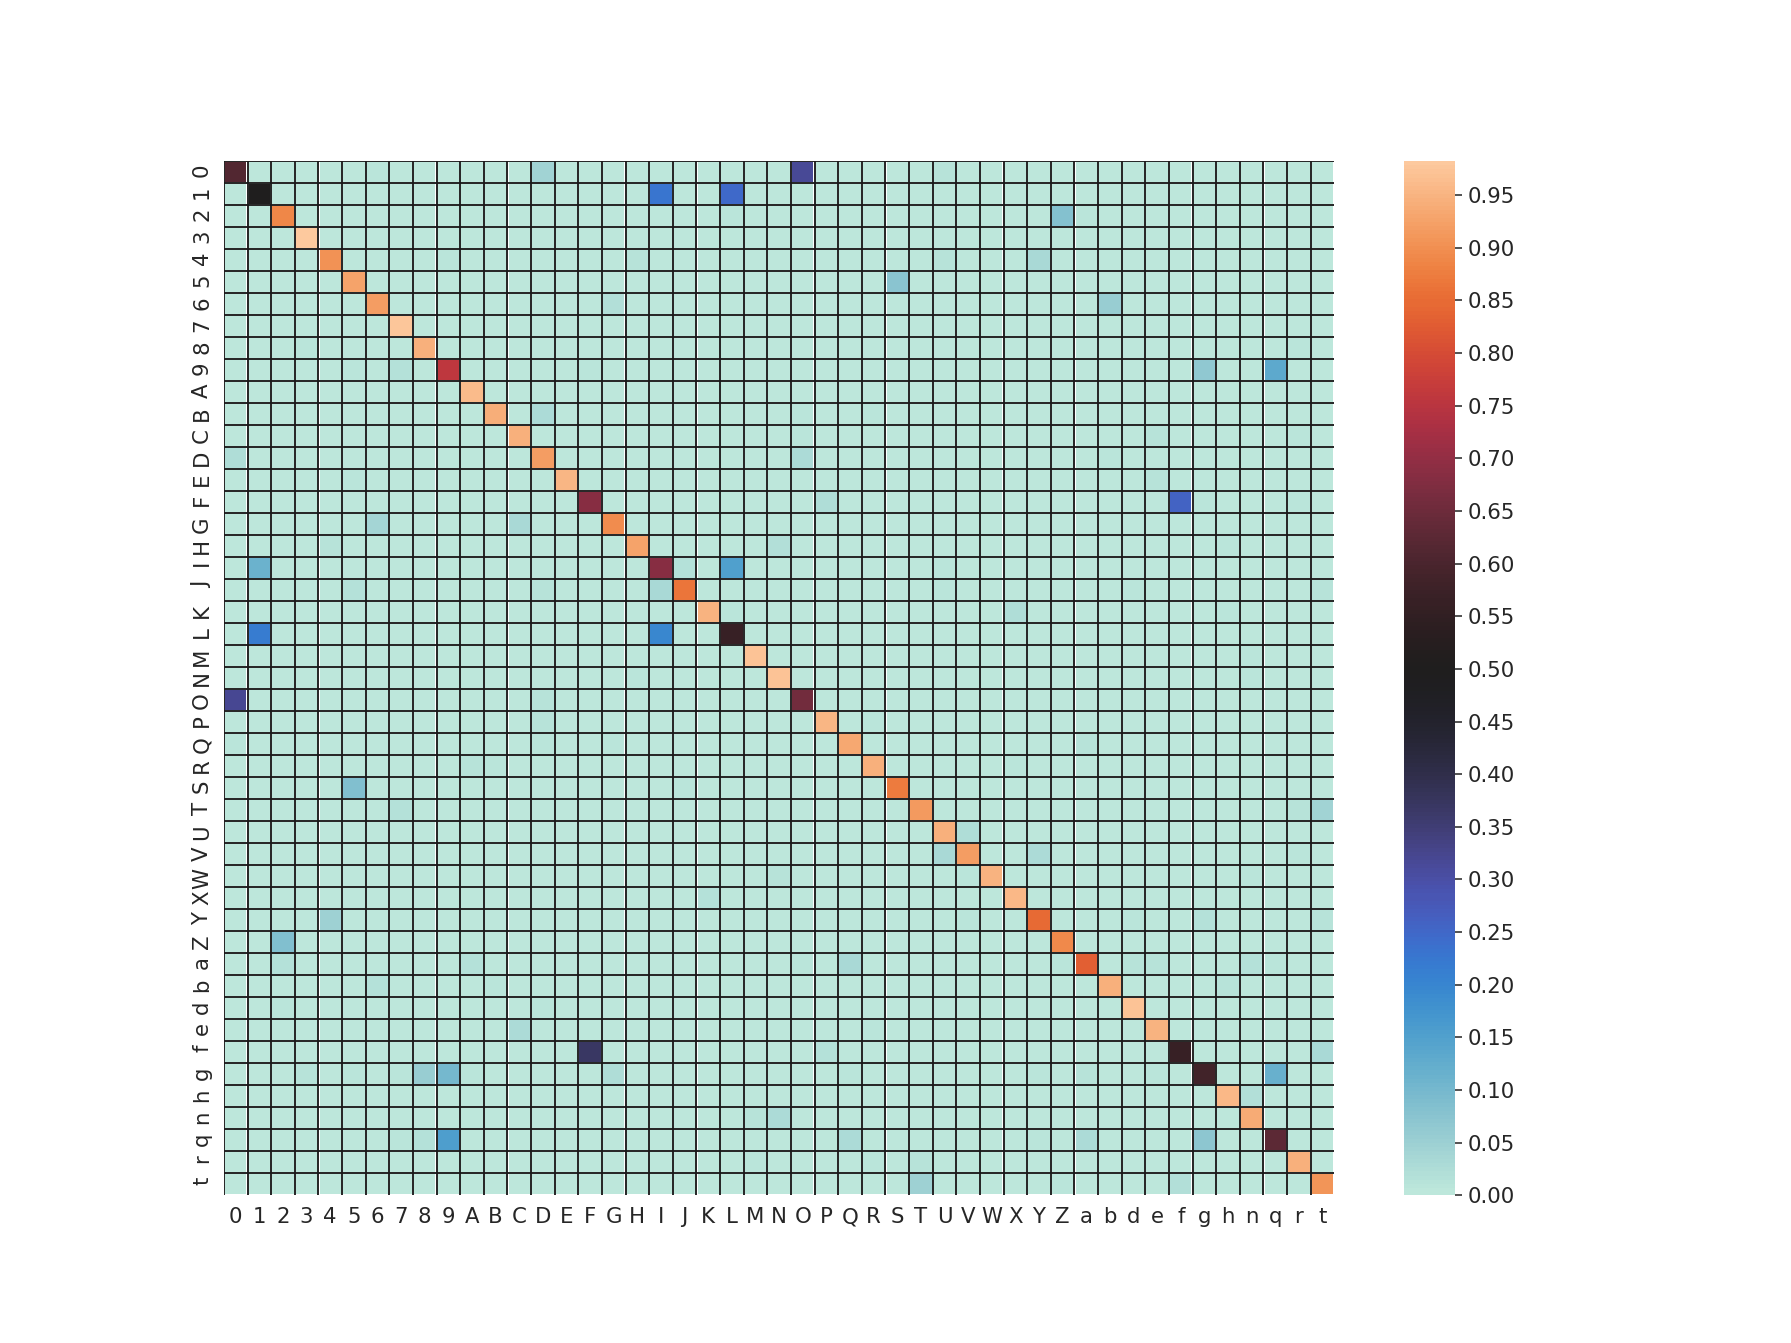

In [49]:
mpl.rcParams['figure.figsize'] = 20,15
heat_map_df = pd.DataFrame(heat_map_data/heat_map_data.sum(axis=1,  keepdims = True), columns = [labels_map[i] for i in range(47)], 
                           index = [labels_map[i] for i in range(47)] )
#sb.palplot(sb.diverging_palette(200, 100, n=47)) cmap="cubehelix" 
ax = sb.heatmap(heat_map_df, annot=False, cbar=True,cbar_kws={"ticks":[0.05*i for i in range(21)]},
            linewidth=1.0, center=0.5)
plt.savefig('../../spiking_networks/emnist_results/heatmap_regular_backprop_final_cmap.pdf',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/heatmap_regular_backprop_fina_cmapl.png',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/heatmap_regular_backprop_final_cmap.eps',bbox_inches='tight')
sb.set(font_scale=1.55)
ax.hlines([range(47)], *ax.get_xlim())
ax.vlines([range(47)], *ax.get_xlim())
plt.show()

<IPython.core.display.Javascript object>


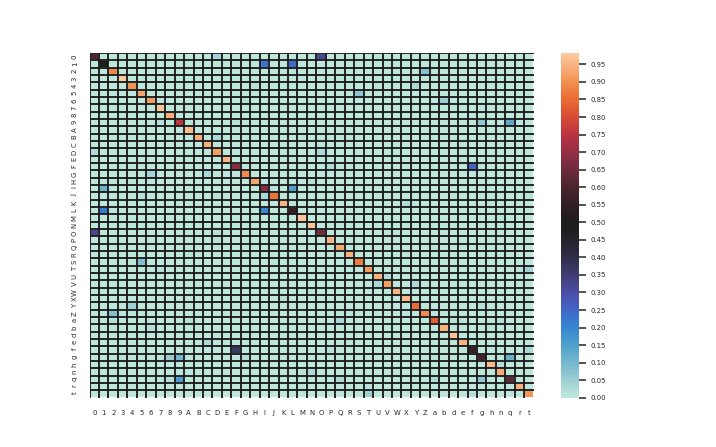

In [52]:
mpl.rcParams['figure.figsize'] = 8,5
heat_map_df = pd.DataFrame(heat_map_data/heat_map_data.sum(axis=1,  keepdims = True), columns = [labels_map[i] for i in range(47)], 
                           index = [labels_map[i] for i in range(47)] )
#sb.palplot(sb.diverging_palette(200, 100, n=47)) cmap="cubehelix" 
ax = sb.heatmap(heat_map_df, annot=False, cbar=True,cbar_kws={"ticks":[0.05*i for i in range(21)]},
            linewidth=0.5, center=0.5)
plt.savefig('../../spiking_networks/emnist_results/heatmap_regular_backprop_final_ieee.pdf',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/heatmap_regular_backprop_fina_ieee.png',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/heatmap_regular_backprop_final_ieee.eps',bbox_inches='tight')
sb.set(font_scale=0.5)
ax.hlines([range(47)], *ax.get_xlim())
ax.vlines([range(47)], *ax.get_xlim())
plt.show()

In [39]:
heat_map_df.loc['0',:].sum()

1.0

<IPython.core.display.Javascript object>


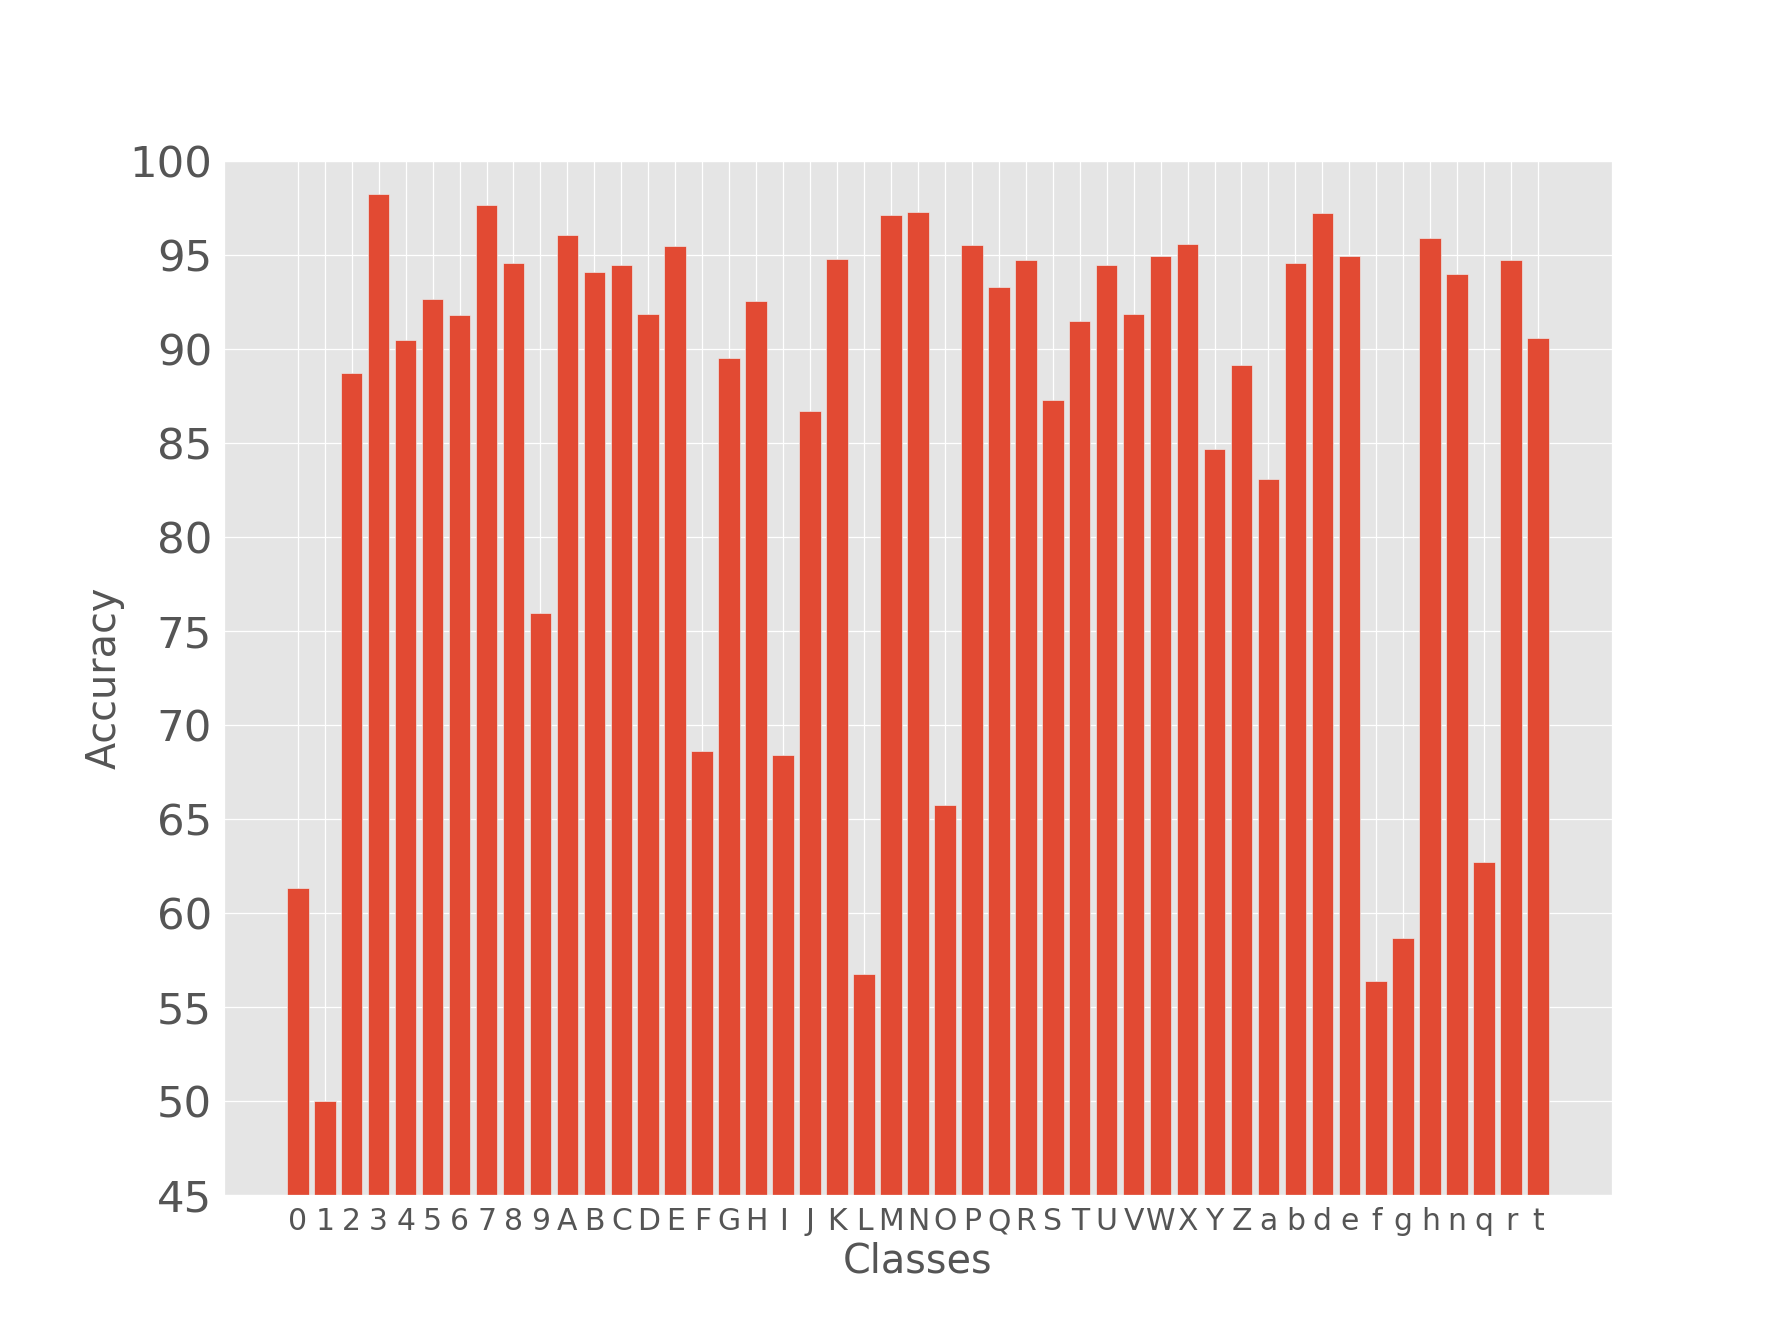

In [59]:
mpl.rcParams['figure.figsize'] = 20,15
plt.style.use('ggplot')
classwise_accuracy = 100*np.array(correct_classifications_per_class)/np.array(samples_per_class)
plt.bar(range(len(classwise_accuracy)), classwise_accuracy)
#plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.0)
plt.grid(b=True, which='minor', color='w', linestyle='-', alpha=1.0)
plt.xlabel('Classes',fontsize=32)
plt.ylabel('Accuracy',fontsize=32)
#plt.xlim(-0.5,len(classwise_accuracy))
plt.yticks([5*i for i in range(21)],fontsize=35)
#plt.yscale('log')
plt.xticks(range(47),[labels_map[i] for i in range(47)],fontsize=24)
plt.ylim(45,100.0)
plt.savefig('../../spiking_networks/emnist_results/acc_per_class_regular_backprop_final.pdf',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/acc_per_class_regular_backprop_final.png',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/acc_per_class_regular_backprop_final.eps',bbox_inches='tight')
plt.show()


In [60]:
print('Accuracy on numbers:{}'.format(classwise_accuracy[0:10].mean()))

Accuracy on numbers:84.1425312888


* Load all the training data and split it

In [63]:
filename ='../../spiking_networks/emnist_train_on_x.h5'
with h5py.File(filename, 'r') as hf:
    on_sparse = hf['on_time_tensor'][:]
filename ='../../spiking_networks/emnist_train_off_x.h5'
with h5py.File(filename, 'r') as hf:
    off_sparse = hf['off_time_tensor'][:]
    
filehandle = open('../../spiking_networks/emnist_train_y.pkl','rb')
class_labels_train = pickle.load(filehandle).astype(np.int).tolist()
filehandle.close()

train_input_images = np.zeros((27,27,2,12*112799),dtype = np.bool_)
train_input_images[:,:,0,:] = on_sparse
train_input_images[:,:,1,:] = off_sparse

train_input_images = np.split(train_input_images, range(12,train_input_images.shape[-1],12), axis = 3)
n_images = len(train_input_images)
del on_sparse
del off_sparse
valid_input_images = train_input_images[0:int(0.09*n_images)]

In [64]:
len(valid_input_images)

10151

In [65]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

* Evaluate predicted labels and actual labels

In [66]:
predicted_labels = []
actual_labels = []
images = []
for index in range(len(wrong_classify_indices)):
    #inspct_right_wrong = 'wrong'
    #if(inspct_right_wrong == 'right'):
    #    sample_2_inspect = right_classify_indices[index]
    #else:
    sample_2_inspect = wrong_classify_indices[index]
    
    actual_label = np.argmax(emnist_valid_labels[sample_2_inspect])
    actual_labels.append(labels_map[actual_label])
    #print('Actual label:{}'.format(actual_label))
    #if(inspct_right_wrong == 'right'):
    #    print('Predicted label:{}'.format(right_predict_labels[index]))
    #else:
    predicted_label = wrong_predict_labels[index]
    predicted_labels.append(labels_map[predicted_label])
    #print('Predicted label:{}'.format(predicted_label))
    #print('Actual Image')
    image = valid_input_images[sample_2_inspect][:,:,0,:].sum(axis=-1)
    images.append(image)
    #plt.imshow()
    #plt.show()


* Plot the predicted and actual labels with images

In [67]:
print(predicted_labels[0:4])
print(actual_labels[0:4])

['f', 'I', 'W', 'n']
['F', '1', 'f', 'h']


<IPython.core.display.Javascript object>


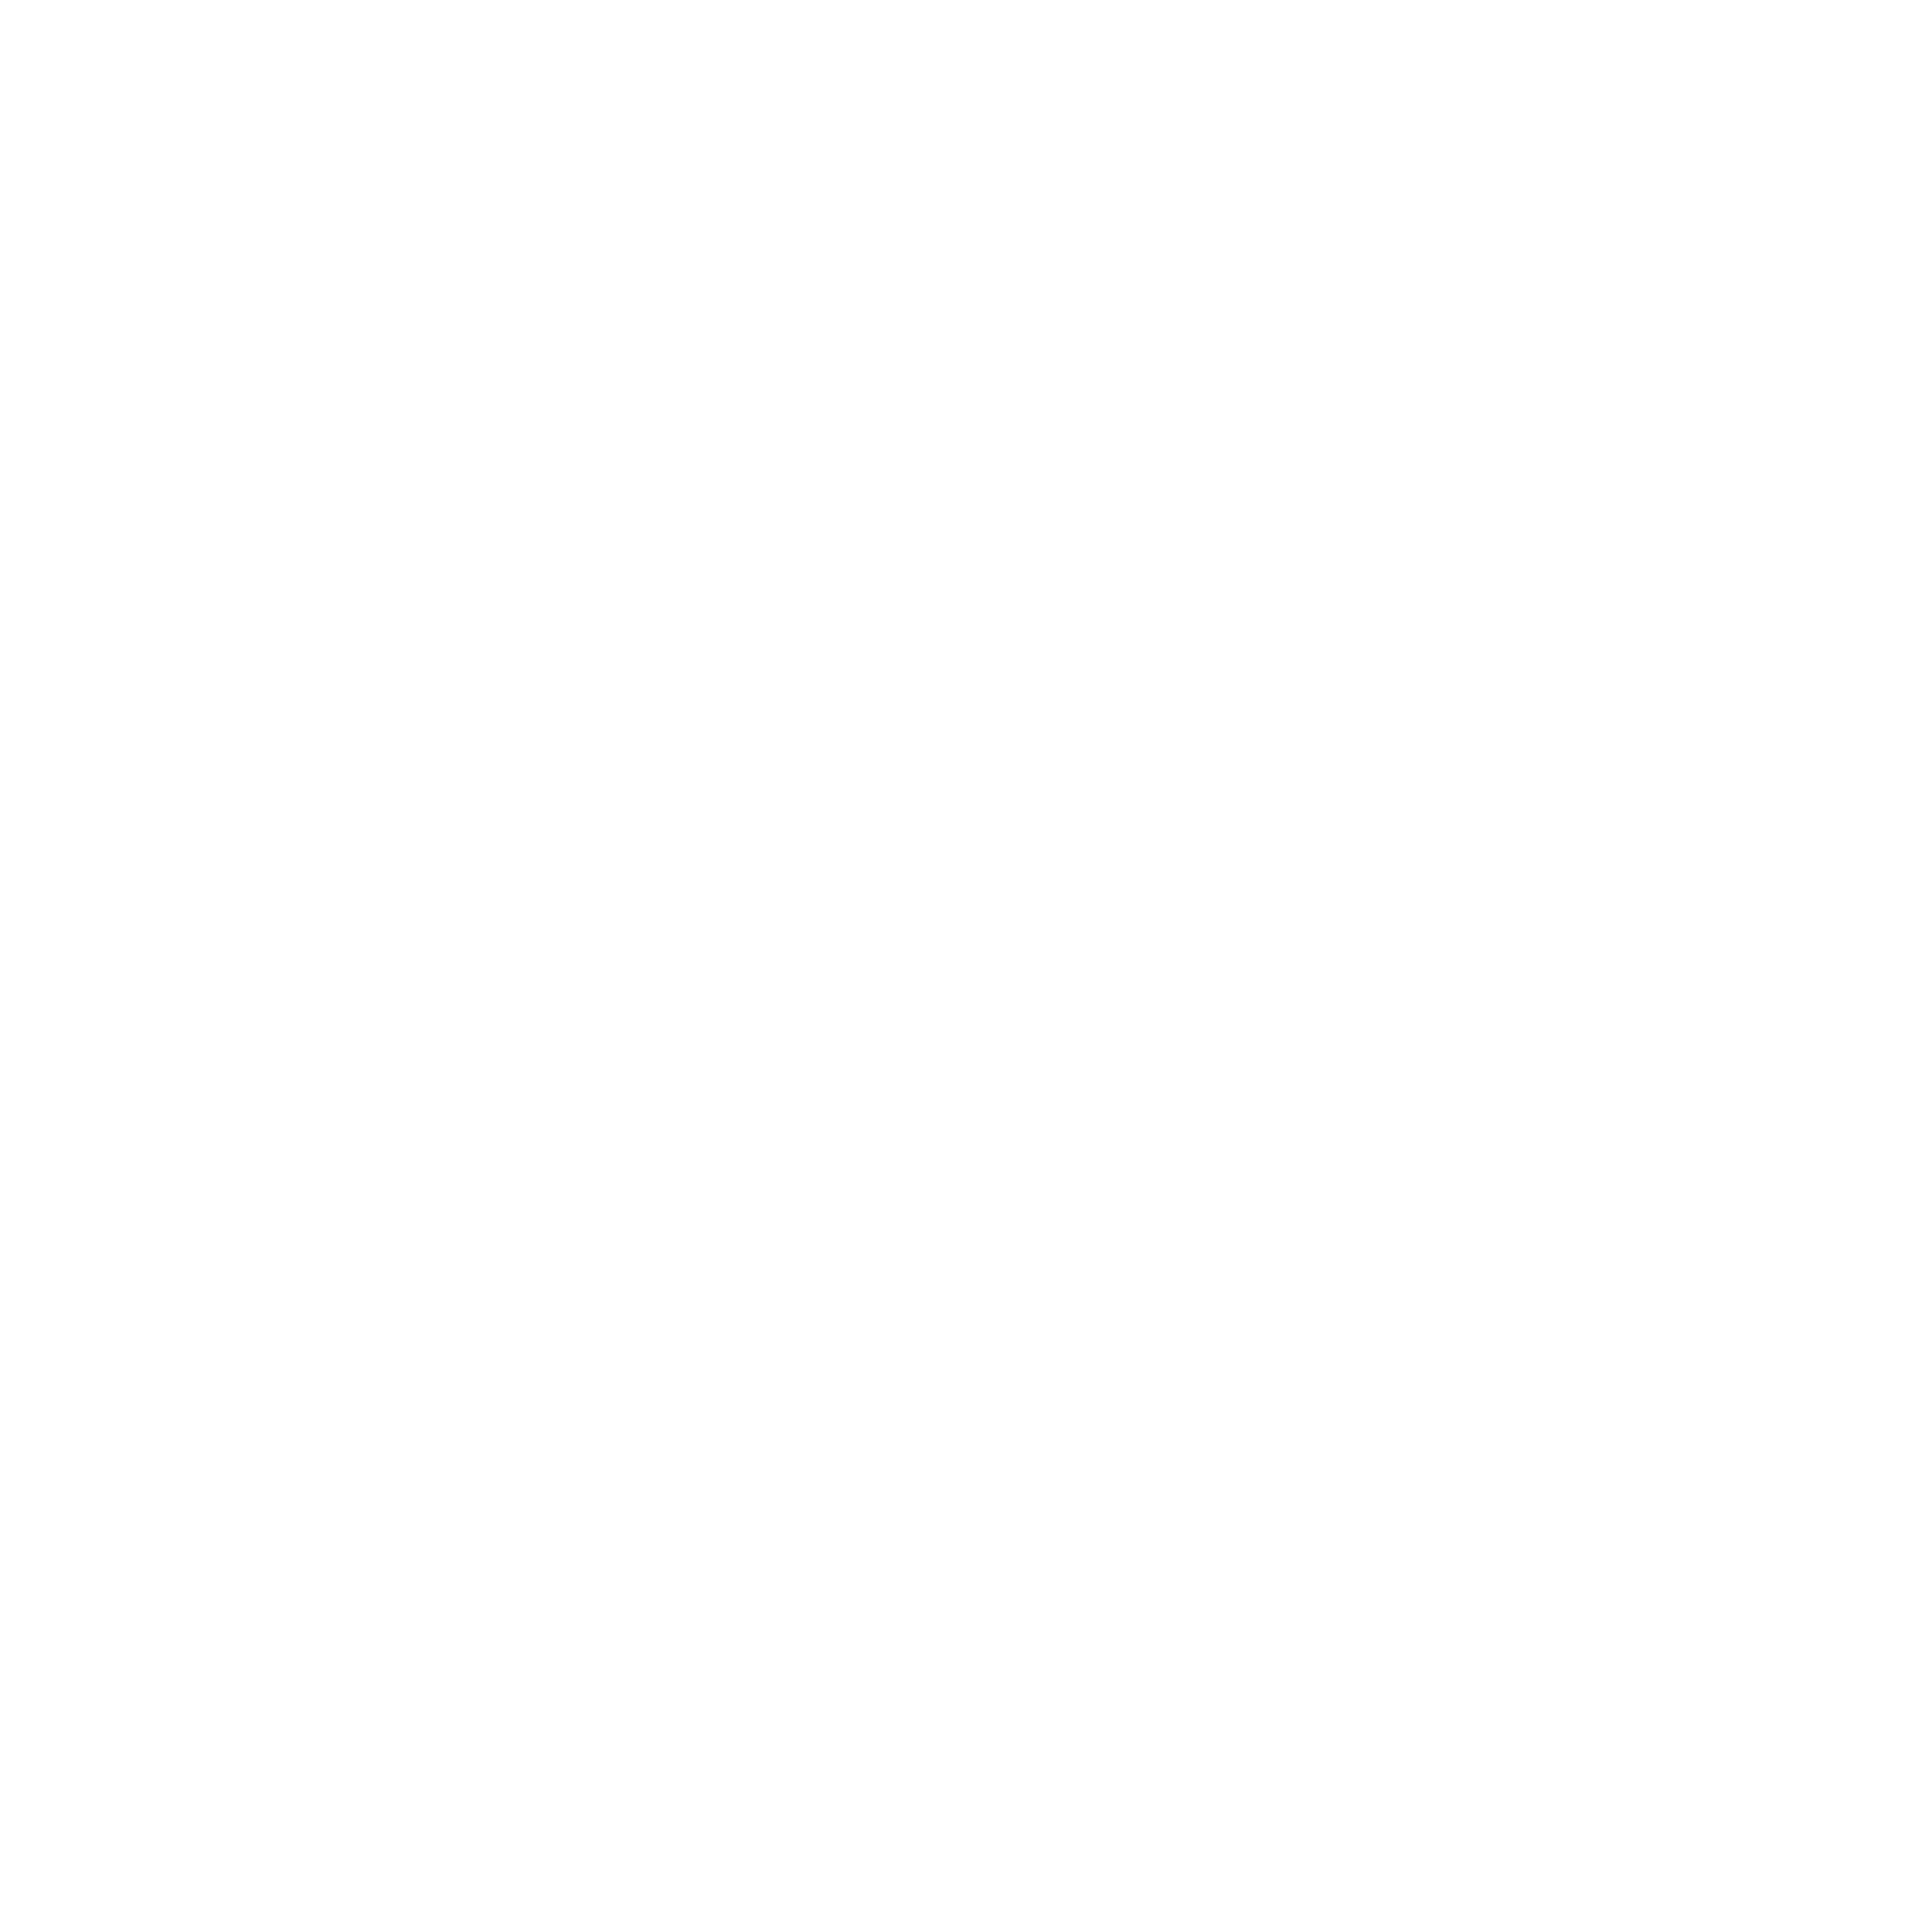

IOError: [Errno 2] No such file or directory: 'emnist_results/misclass_regular_backprop_final.pdf'

In [68]:
plotx = 35
ploty = 35
fig, axes = plt.subplots(plotx, ploty,subplot_kw={'xticks': [], 'yticks': []},figsize = (35,35))
fig.subplots_adjust(left=0.00, bottom=0.00, right=1.0, top=0.95, wspace=0.0, hspace=0.32)
axes = axes.flat
for i in range(len(axes)):
    axes[i].imshow(images[i],interpolation='none',cmap='gray')
    axes[i].set_title('P:'+predicted_labels[i]+' ,L:'+actual_labels[i],fontsize=18)
plt.savefig('emnist_results/misclass_regular_backprop_final.pdf')
plt.savefig('emnist_results/misclass_regular_backprop_final.png')
plt.savefig('emnist_results/misclass_regular_backprop_final.eps')
plt.show()


### Collapsing labels

In [69]:
inv_map = {v: k for k, v in labels_map.items()}
collapsed_labels_pairs = [(inv_map['f'],inv_map['F']),(inv_map['0'],inv_map['O']),(inv_map['q'],inv_map['9']),
                   (inv_map['1'],inv_map['L'],inv_map['I']),(inv_map['S'],inv_map['5']),
                   (inv_map['2'],inv_map['Z'])]
print(collapsed_labels_pairs)
print()
collapsed_labels_dict = {}
for item in collapsed_labels_pairs:
    if(len(item)!=3):
        collapsed_labels_dict[item[0]]=[item[0],item[1]]
        collapsed_labels_dict[item[1]]=[item[0],item[1]]
    else:
        collapsed_labels_dict[item[0]]=[item[0],item[1],item[2]]
        collapsed_labels_dict[item[1]]=[item[0],item[1],item[2]]
        collapsed_labels_dict[item[2]]=[item[0],item[1],item[2]]
print(collapsed_labels_dict)
print()
all_collapsed_labels = collapsed_labels_dict.keys()
print(all_collapsed_labels)

[(40, 15), (0, 24), (44, 9), (1, 21, 18), (28, 5), (2, 35)]
()
{0: [0, 24], 1: [1, 21, 18], 2: [2, 35], 35: [2, 35], 5: [28, 5], 40: [40, 15], 9: [44, 9], 44: [44, 9], 15: [40, 15], 18: [1, 21, 18], 21: [1, 21, 18], 24: [0, 24], 28: [28, 5]}
()
[0, 1, 2, 35, 5, 40, 9, 44, 15, 18, 21, 24, 28]


In [70]:
original_valid_labels_scalar = emnist_valid_labels.argmax(axis=1)
original_test_labels_scalar = emnist_test_labels.argmax(axis=1)

In [71]:
print(best_predictions[0:10])
print(original_valid_labels_scalar[0:10])

[45 36 43 40  4 42 26 32 20 18]
[45 36 43 15  4 42 26 32 20  1]


### Validation accuracy on collapsed labels

In [72]:
correct_preds = 0
##note that below variables are recorded only for mis matches
collapsed_predicted_labels = []
collapsed_actual_labels = []
collapsed_mis_match_ids = []
collapsed_mis_match_images = []
for i in range(len(original_valid_labels_scalar)):
    true_label = original_valid_labels_scalar[i]
    if(true_label in all_collapsed_labels):
        if(best_predictions[i] in collapsed_labels_dict[true_label]):
            correct_preds+=1
        else:
            correct_preds+=0
            collapsed_predicted_labels.append(labels_map[best_predictions[i]])
            collapsed_actual_labels.append(labels_map[true_label])
            collapsed_mis_match_ids.append(i)
            collapsed_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
    else:
        if(true_label == best_predictions[i]):
            correct_preds+=1
        else:
            correct_preds+=0
            collapsed_predicted_labels.append(labels_map[best_predictions[i]])
            collapsed_actual_labels.append(labels_map[true_label])
            collapsed_mis_match_ids.append(i)
            collapsed_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
print('Number of mis-matches:{}'.format(len(collapsed_mis_match_ids)))
print('Validation accuracy with collapsed labels:{}'.format(float(correct_preds)/len(original_valid_labels_scalar)))

Number of mis-matches:704
Validation accuracy with collapsed labels:0.930647226874


In [ ]:
plotx = 26
ploty = 26
fig, axes = plt.subplots(plotx, ploty,subplot_kw={'xticks': [], 'yticks': []},figsize = (26,26))
fig.subplots_adjust(left=0.00, bottom=0.00, right=1.0, top=0.95, wspace=0.0, hspace=0.32)
axes = axes.flat
for i in range(len(axes)):
    axes[i].imshow(collapsed_mis_match_images[i],interpolation='none',cmap='gray')
    axes[i].set_title('P:'+collapsed_predicted_labels[i]+' ,L:'+collapsed_actual_labels[i],fontsize=18)
plt.savefig('emnist_results/collapsed_misclass_regular_backprop_final.pdf')
plt.savefig('emnist_results/collapsed_misclass_regular_backprop_final.png')
plt.savefig('emnist_results/collapsed_misclass_regular_backprop_final.eps')
plt.show()


### Test accuracy with best weights

In [73]:
correct_preds = 0
##note that below variables are recorded only for mis matches
collapsed_predicted_labels = []
collapsed_actual_labels = []
collapsed_mis_match_ids = []
for i in range(len(original_test_labels_scalar)):
    true_label = original_test_labels_scalar[i]
    if(true_label in all_collapsed_labels):
        if(best_predictions_test[i] in collapsed_labels_dict[true_label]):
            correct_preds+=1
        else:
            correct_preds+=0
            collapsed_predicted_labels.append(labels_map[best_predictions_test[i]])
            collapsed_actual_labels.append(labels_map[true_label])
            collapsed_mis_match_ids.append(i)
    else:
        if(true_label == best_predictions_test[i]):
            correct_preds+=1
        else:
            correct_preds+=0
            collapsed_predicted_labels.append(labels_map[best_predictions_test[i]])
            collapsed_actual_labels.append(labels_map[true_label])
            collapsed_mis_match_ids.append(i)
print('Number of mis-matches:{}'.format(len(collapsed_mis_match_ids)))
print('Test accuracy with collapsed labels:{}'.format(float(correct_preds)/len(original_test_labels_scalar)))

Number of mis-matches:1473
Test accuracy with collapsed labels:0.92164893617


### Inspecting mis classified samples in `[f,F,0,O,q,9,1,I,L,S,5,2,Z]`

In [104]:
predicted_labels_select = []
actual_labels_select = []
images_select = []
for index in range(len(wrong_classify_indices)):
    #inspct_right_wrong = 'wrong'
    #if(inspct_right_wrong == 'right'):
    #    sample_2_inspect = right_classify_indices[index]
    #else:
    sample_2_inspect = wrong_classify_indices[index]
    
    actual_label = np.argmax(emnist_valid_labels[sample_2_inspect])
    if(actual_label in all_collapsed_labels):
        actual_labels_select.append(labels_map[actual_label])
        predicted_label_select = wrong_predict_labels[index]
        predicted_labels_select.append(labels_map[predicted_label_select])
        image = valid_input_images[sample_2_inspect][:,:,0,:].sum(axis=-1)
        images_select.append(image)


<IPython.core.display.Javascript object>


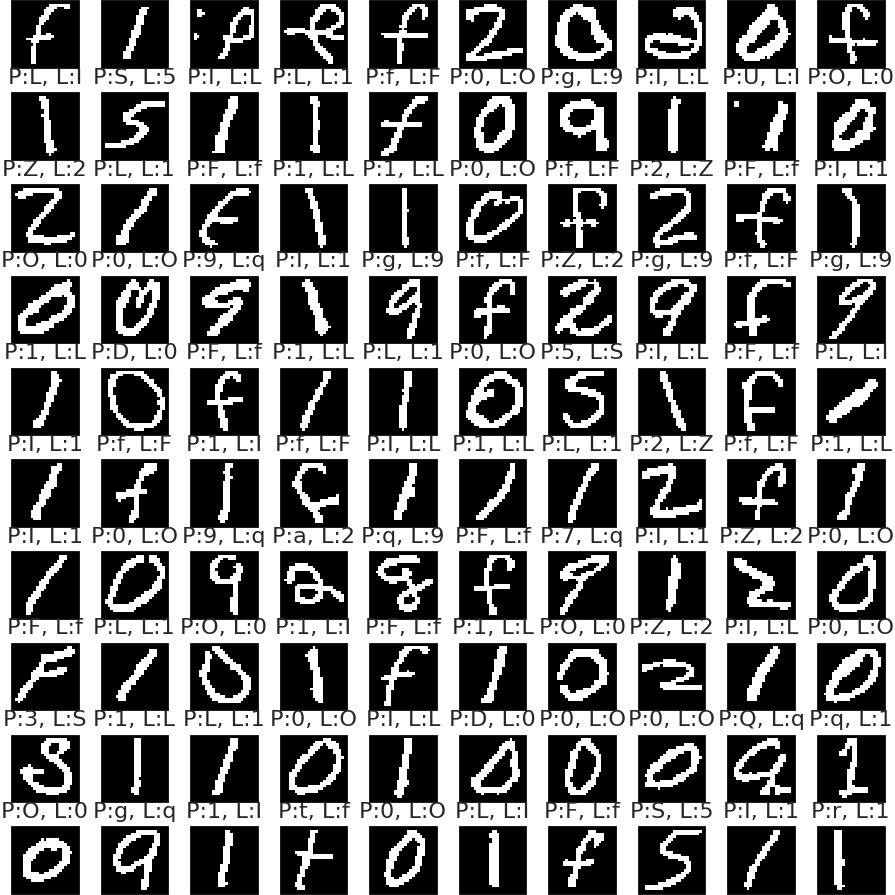

In [76]:
plotx = 10
ploty = 10
fig, axes = plt.subplots(plotx, ploty,subplot_kw={'xticks': [], 'yticks': []},figsize = (10,10))
fig.subplots_adjust(left=0.00, bottom=0.00, right=1.0, top=1.0, wspace=0.0, hspace=0.32)
axes = axes.flat
for i in range(len(axes)):
    axes[i].imshow(images_select[i],interpolation='none',cmap='gray')
    axes[i].set_title('P:'+predicted_labels_select[i]+', L:'+actual_labels_select[i],fontsize=18)
plt.savefig('../../spiking_networks/emnist_results/misclass_selected_regular_backprop_final.pdf')
plt.savefig('../../spiking_networks/emnist_results/misclass_selected_regular_backprop_final.png')
plt.savefig('../../spiking_networks/emnist_results/misclass_selected_regular_backprop_final.eps')
plt.show()


<IPython.core.display.Javascript object>


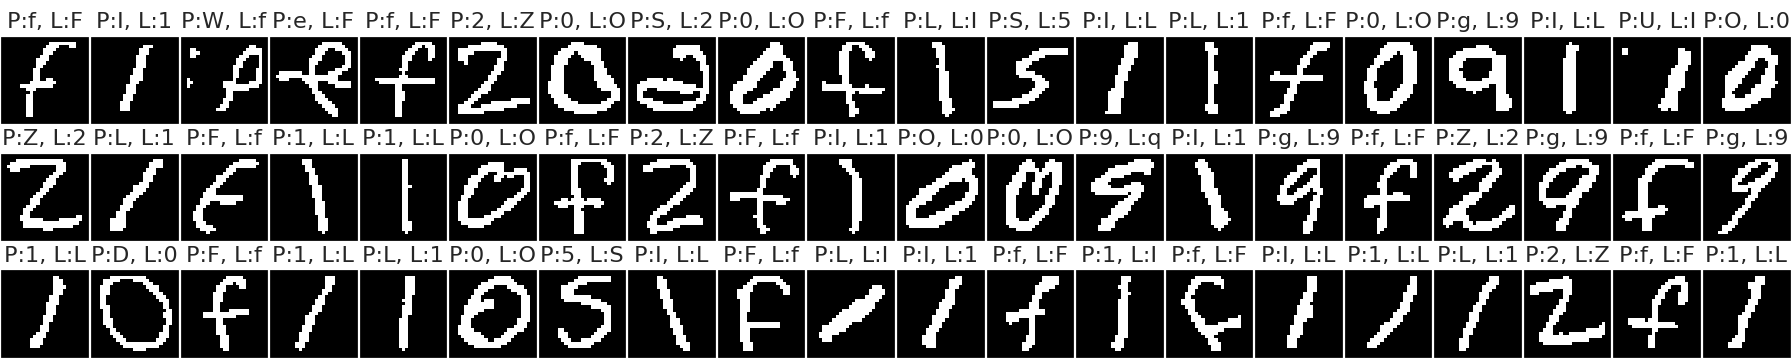

In [107]:
plotx = 3
ploty = 20
fig, axes = plt.subplots(plotx, ploty,subplot_kw={'xticks': [], 'yticks': []},figsize = (20,4))
fig.subplots_adjust(left=0.00, bottom=0.00, right=1.0, top=0.9, wspace=0.0, hspace=0.32)
axes = axes.flat
for i in range(len(axes)):
    axes[i].imshow(images_select[i],interpolation='none',cmap='gray')
    axes[i].set_title('P:'+predicted_labels_select[i]+', L:'+actual_labels_select[i],fontsize=18)
plt.savefig('../../spiking_networks/emnist_results/misclass_selected_regular_backprop_final_ieee.pdf')
plt.savefig('../../spiking_networks/emnist_results/misclass_selected_regular_backprop_final_ieee.png')
plt.savefig('../../spiking_networks/emnist_results/misclass_selected_regular_backprop_final_ieee.eps')
plt.show()


### Accuracy with conditioning
* In this section we will condition the labels predict the label given that the actual label is a numeric or an upper case alphabet or a lower case alphabet

In [88]:
numerics = list(range(0,10))
upper_cases = list(range(10,36))
lower_cases = list(range(36,47))
print(numerics)
print(upper_cases)
print(lower_cases)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]


* Accuracy of the best validation predictions

In [89]:
req_activations = best_activations

In [90]:
correct_preds = 0
##note that below variables are recorded only for mis matches
conditioned_predicted_labels = []
conditioned_actual_labels = []
conditioned_mis_match_ids = []
conditioned_mis_match_images = []
samples_per_class = [0]*47
correct_classifications_per_class = [0]*47
heat_map_data = np.array([[[0.0]*47]*47])
heat_map_data = heat_map_data[0]
for i in range(len(original_valid_labels_scalar)):
    true_label = original_valid_labels_scalar[i]
    samples_per_class[true_label]+=1.0
    if(true_label in numerics):
        predicted_label = req_activations[i][numerics].argmax()
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in upper_cases):
        predicted_label = req_activations[i][upper_cases].argmax() + len(numerics)
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in lower_cases):
        predicted_label = req_activations[i][lower_cases].argmax() + len(upper_cases) + len(numerics)
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
print('Number of mis-matches:{}'.format(len(conditioned_mis_match_ids)))
print('Validation aaccuracy with conditioned labels:{}'.format(float(correct_preds)/len(original_valid_labels_scalar)))

Number of mis-matches:537
Validation aaccuracy with conditioned labels:0.947098807999


In [91]:
heat_map_df = pd.DataFrame(heat_map_data/heat_map_data.sum(axis=1, keepdims=True), columns = [labels_map[i] for i in range(47)], 
                           index = [labels_map[i] for i in range(47)] )

In [92]:
heat_map_df.head(15)

,0,1,2,3,4,5,6,7,8,9,...,b,d,e,f,g,h,n,q,r,t
0,0.976415,0.000000,0.000000,0.000000,0.009434,0.000000,0.014151,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.990654,0.004673,0.000000,0.000000,0.000000,0.004673,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.995495,0.000000,0.000000,0.000000,0.000000,0.004505,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.991266,0.000000,0.004367,0.000000,0.004367,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.972851,0.000000,0.004525,0.004525,0.004525,0.013575,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.005263,0.000000,0.994737,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.009132,0.000000,0.000000,0.000000,0.000000,0.000000,0.990868,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.004651,0.000000,0.000000,0.000000,0.000000,0.990698,0.000000,0.004651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.004545,0.000000,0.000000,0.009091,0.004545,0.013636,0.000000,0.004545,0.963636,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.004367,0.000000,0.000000,0.000000,0.008734,0.017467,0.000000,0.026201,0.008734,0.934498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


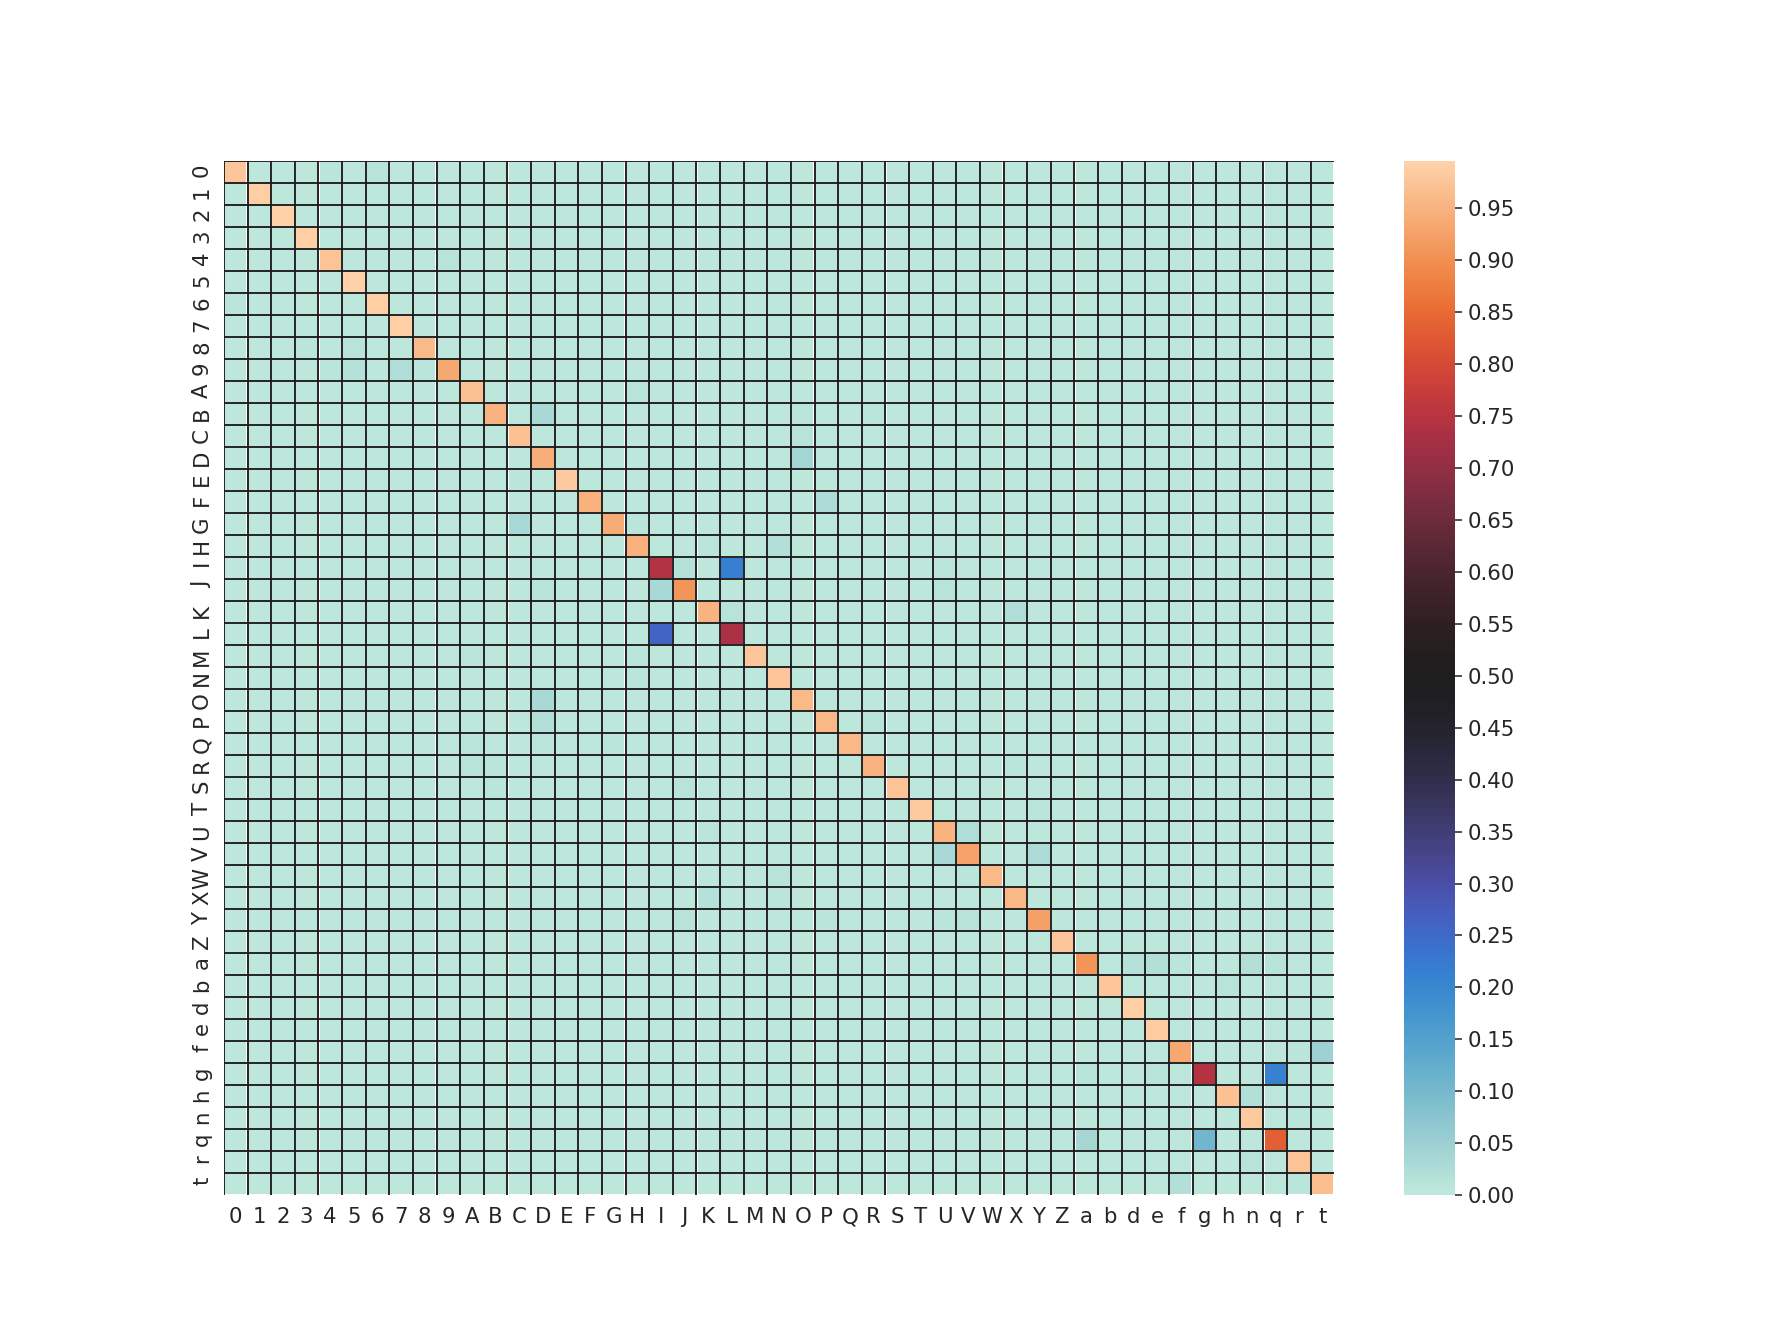

In [94]:
#plt.savefig('emnist_results/heatmap_cond_regular_backprop_final.pdf'
#plt.savefig('emnist_results/heatmap_cond_regular_backprop_final.png')
#plt.savefig('emnist_results/heatmap_cond_regular_backprop_final.eps')
mpl.rcParams['figure.figsize'] = 20,15
heat_map_df = pd.DataFrame(heat_map_data/heat_map_data.sum(axis=1,  keepdims = True), columns = [labels_map[i] for i in range(47)], 
                           index = [labels_map[i] for i in range(47)] )
#sb.palplot(sb.diverging_palette(200, 100, n=47)) cmap="cubehelix" 
ax = sb.heatmap(heat_map_df, annot=False, cbar=True,cbar_kws={"ticks":[0.05*i for i in range(21)]},
            linewidth=1.0, center=0.5)
plt.savefig('../../spiking_networks/emnist_results/heatmap_cond_regular_backprop_final_cmap.pdf',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/heatmap_cond_regular_backprop_final_cmap.png',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/heatmap_cond_regular_backprop_final_cmap.eps',bbox_inches='tight')
sb.set(font_scale=1.65)
ax.hlines([range(47)], *ax.get_xlim())
ax.vlines([range(47)], *ax.get_xlim())
plt.show()

In [95]:
print(heat_map_df.loc['q','g'],heat_map_df.loc['q','q'],heat_map_df.loc['g','q'],heat_map_df.loc['g','g'])

(0.10810810810810811, 0.8324324324324325, 0.2112676056338028, 0.7464788732394366)


In [96]:
print(heat_map_df.loc['q',:].sum())

1.0


In [97]:
print(heat_map_df.loc['I','L'],heat_map_df.loc['I','I'],heat_map_df.loc['L','I'],heat_map_df.loc['L','L'])

(0.215311004784689, 0.7416267942583732, 0.25675675675675674, 0.7342342342342343)


<IPython.core.display.Javascript object>


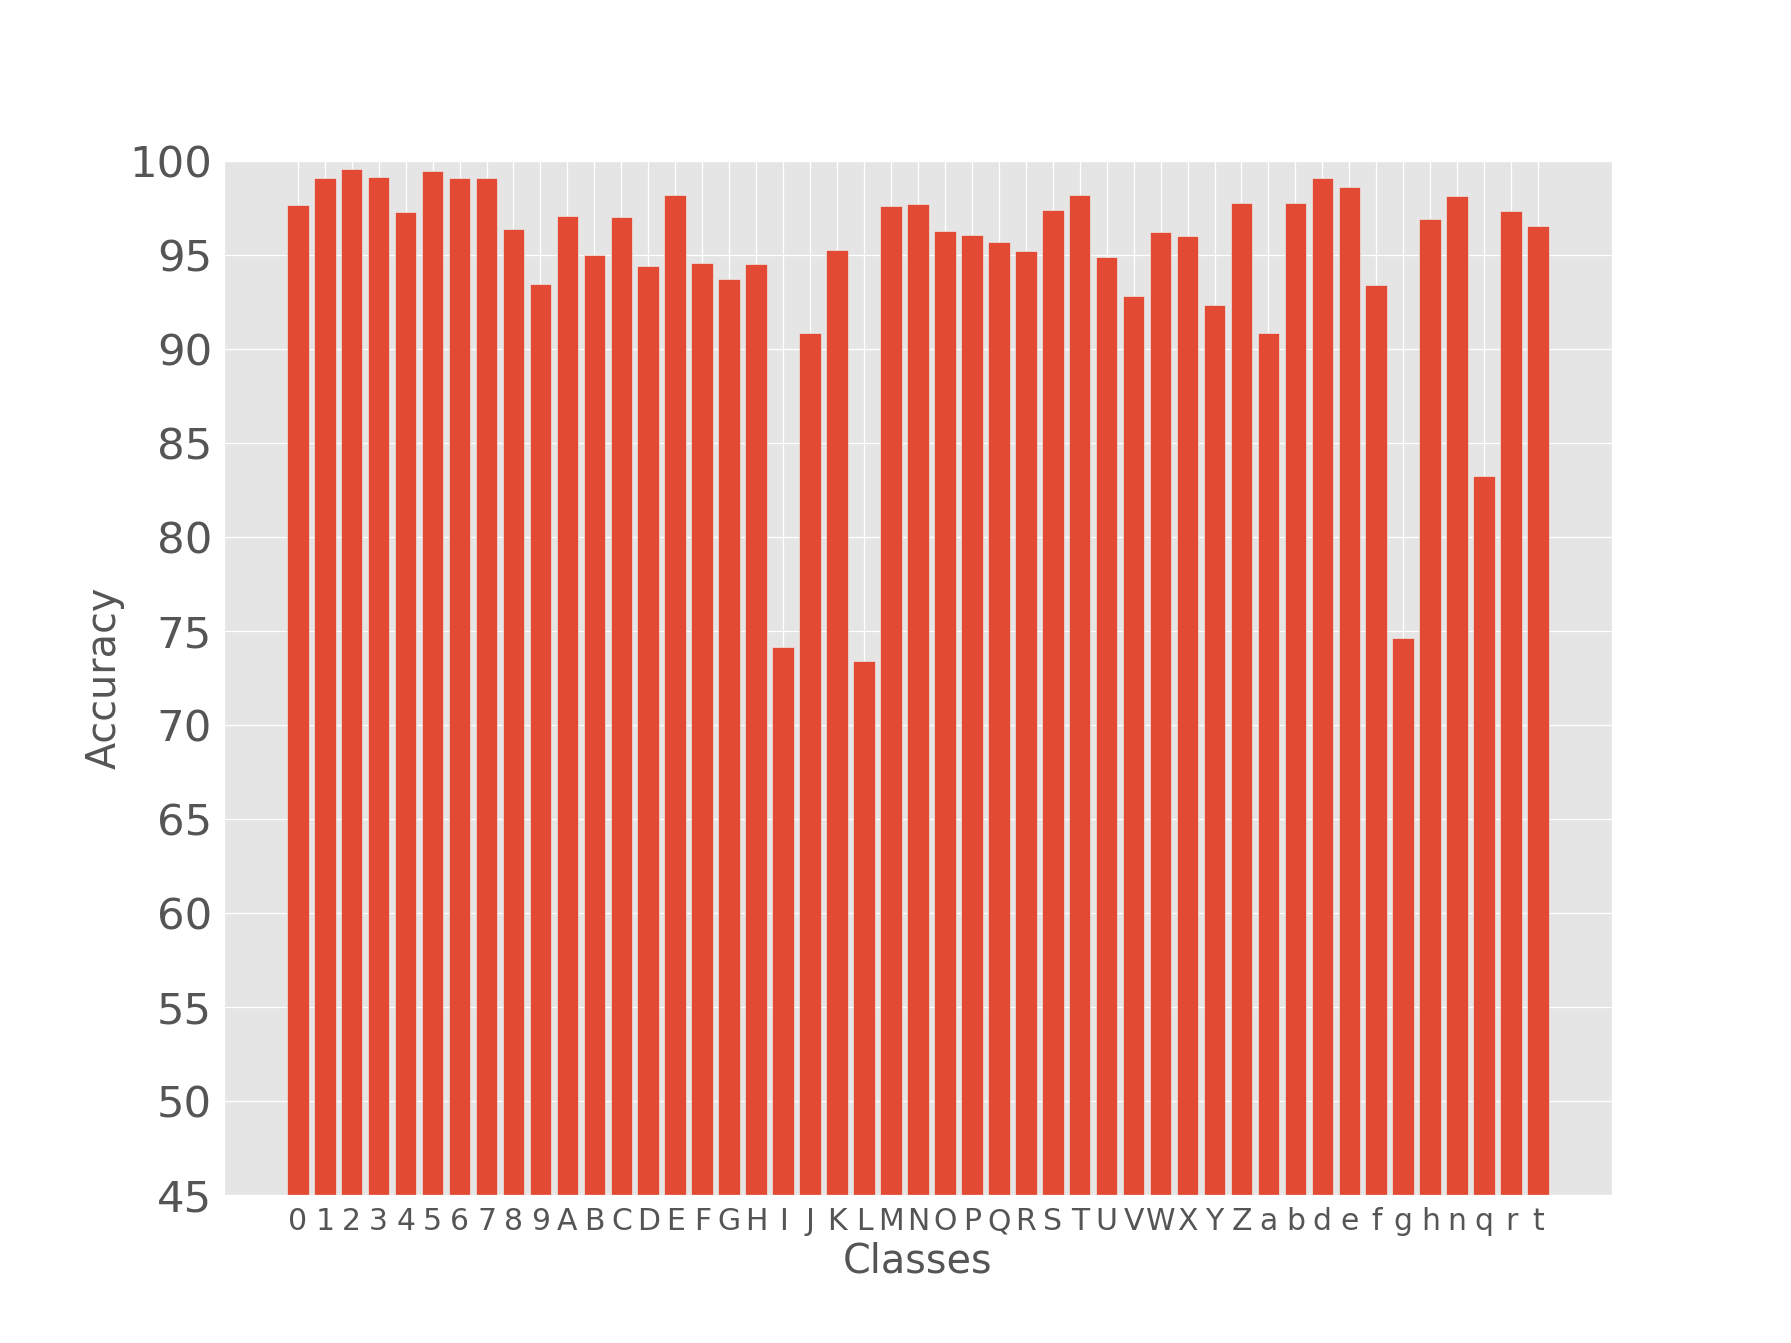

In [98]:
plt.style.use('ggplot')
classwise_accuracy = 100*np.array(correct_classifications_per_class)/np.array(samples_per_class)
plt.bar(range(len(classwise_accuracy)), classwise_accuracy)
#plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.0)
plt.grid(b=True, which='minor', color='w', linestyle='-', alpha=1.0)
plt.xlabel('Classes',fontsize=32)
plt.ylabel('Accuracy',fontsize=32)
#plt.xlim(-0.5,len(classwise_accuracy))
plt.yticks([5*i for i in range(21)],fontsize=35)
#plt.yscale('log')
plt.xticks(range(47),[labels_map[i] for i in range(47)],fontsize=24)
plt.ylim(45,100.0)
plt.savefig('../../spiking_networks/emnist_results/acc_per_class_cond_regular_backprop_final.pdf',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/acc_per_class_cond_regular_backprop_final.png',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/acc_per_class_cond_regular_backprop_final.eps',bbox_inches='tight')
plt.show()


In [99]:
print('Accuracy on numbers:{}'.format(classwise_accuracy[0:10].mean()))

Accuracy on numbers:98.0111812638


<IPython.core.display.Javascript object>


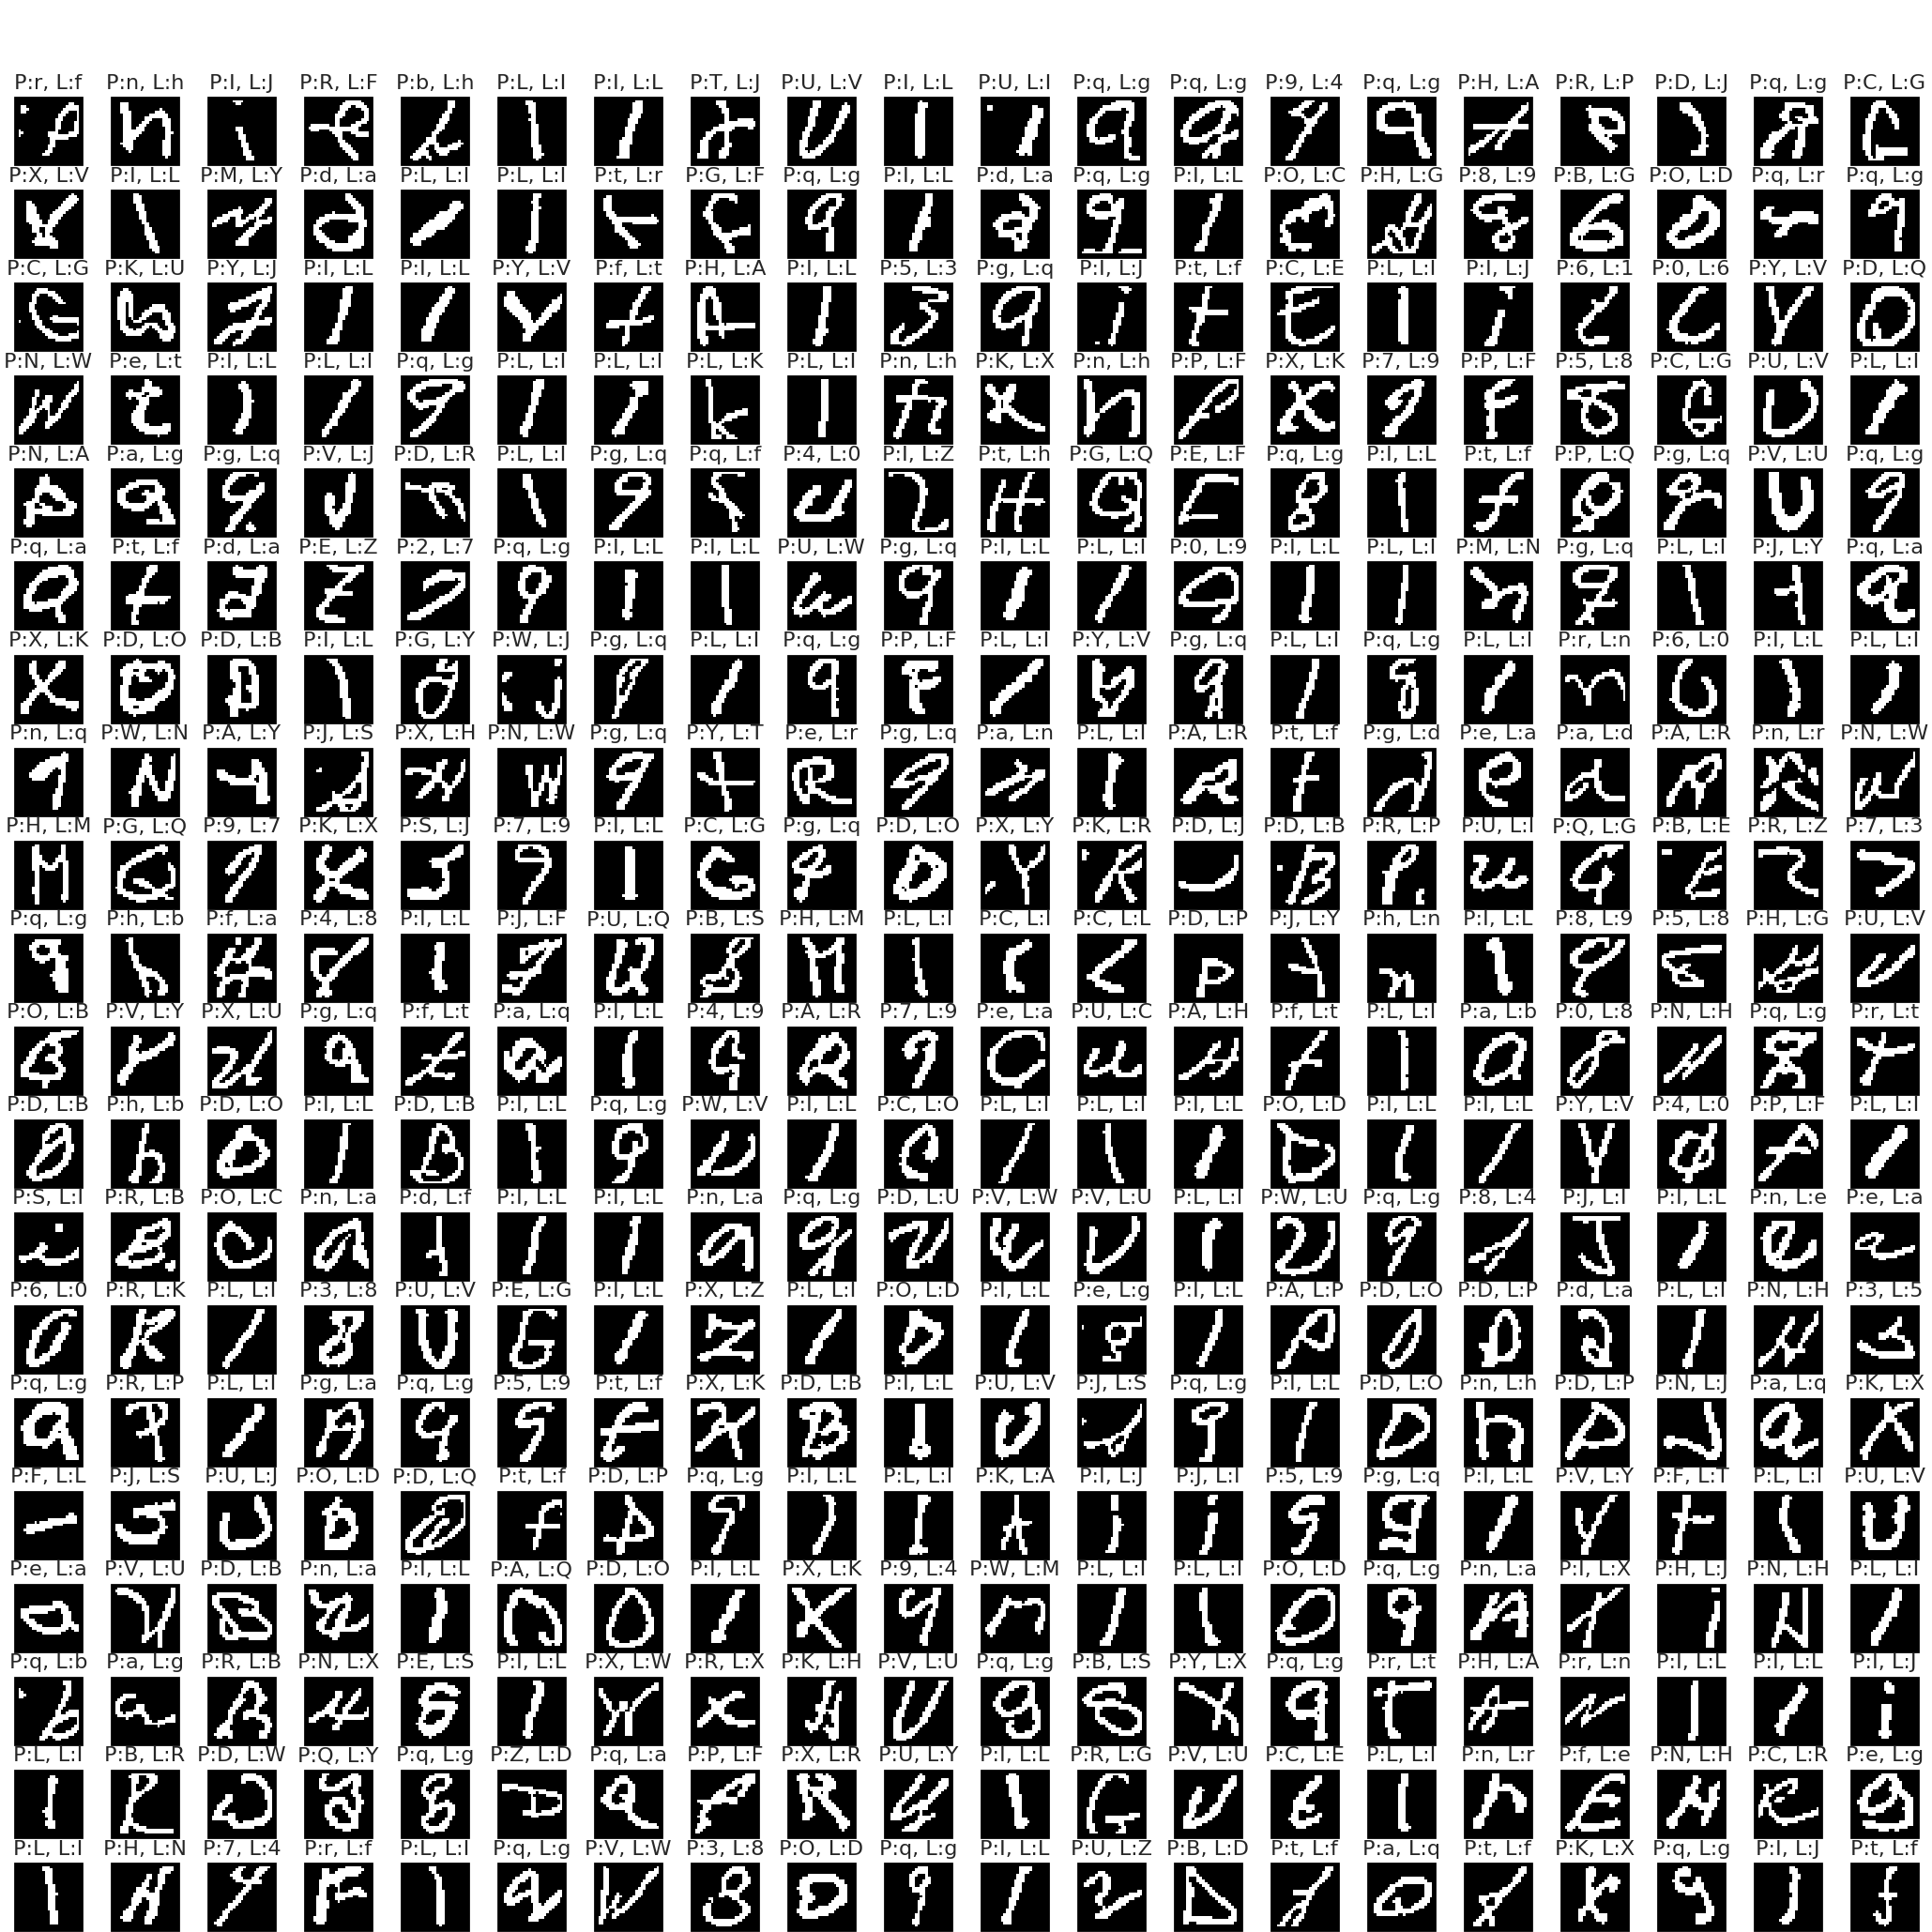

In [101]:
plotx = 20
ploty = 20
fig, axes = plt.subplots(plotx, ploty,subplot_kw={'xticks': [], 'yticks': []},figsize = (23,23))
fig.subplots_adjust(left=0.00, bottom=0.00, right=1.0, top=0.95, wspace=0.0, hspace=0.32)
axes = axes.flat
for i in range(len(axes)):
    axes[i].imshow(conditioned_mis_match_images[i],interpolation='none',cmap='gray')
    axes[i].set_title('P:'+conditioned_predicted_labels[i]+', L:'+conditioned_actual_labels[i],fontsize=18)
plt.savefig('../../spiking_networks/emnist_results/cond_misclass_regular_backprop_final.pdf',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/cond_misclass_regular_backprop_final.png',bbox_inches='tight')
plt.savefig('../../spiking_networks/emnist_results/cond_misclass_regular_backprop_final.eps',bbox_inches='tight')
plt.show()


###  Accuracy on the best test data with conditioning

In [102]:
req_activations = best_activations_test
#req_activations = activations_test.transpose()

In [103]:
correct_preds = 0
##note that below variables are recorded only for mis matches
conditioned_predicted_labels = []
conditioned_actual_labels = []
conditioned_mis_match_ids = []
conditioned_mis_match_images = []
for i in range(len(original_test_labels_scalar)):
    true_label = original_test_labels_scalar[i]
    if(true_label in numerics):
        predicted_label = req_activations[i][numerics].argmax()
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in upper_cases):
        predicted_label = req_activations[i][upper_cases].argmax() + len(numerics)
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in lower_cases):
        predicted_label = req_activations[i][lower_cases].argmax() + len(upper_cases) + len(numerics)
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
print('Number of mis-matches:{}'.format(len(conditioned_mis_match_ids)))
print('Accuracy with conditioned labels:{}'.format(float(correct_preds)/len(original_test_labels_scalar)))

Number of mis-matches:1081
Accuracy with conditioned labels:0.9425


### Cost, validation and accuracy plots

In [ ]:
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(b=True, which='major', color='w', linestyle='-',alpha=1.0)
#plt.grid(b=True, which='minor', color='w', linestyle='-', alpha=1.0)
plt.legend()
plt.show()

In [ ]:
plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.01*i for i in range(1,101)])
plt.ylim(0.75,1.02)
plt.grid(b=True, which='major', color='w', linestyle='-',alpha=1.0)
plt.legend()
plt.show()

## Feedback alignment (Random backprop or FA)

In [ ]:
sess.close()
tf.reset_default_graph()
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

### Network Setup

In [ ]:
n_input = 3630
n_middle = 1500
n_out = 47
batch_size = tf.placeholder(tf.int64, name='batch_size') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

drop_out = tf.placeholder(tf.float32)
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    #w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    tf.summary.histogram('w_2', w_2)
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    tf.summary.histogram('b_2', b_2)
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    #w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    w_3_r = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3_r')
    tf.summary.histogram('w_3', w_3)
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))
def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    #locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]),n_middle*batch_size )
    #locs_to_drop = tf.reshape(locs_to_drop, z_2.shape)
    #locs_to_drop = tf.reshape(locs_to_drop, [n_middle,batch_size])
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = ReLU(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    tf.summary.histogram('z_3', z_3)
    #a_3  = spkNeuron(z_3) ##UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT spike SQUISHING
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),name = 'cost_calc')#WORKS
    ##COMMENT BELOW LINES IF YOU WANT SOFTMAX
    #dc_da = -tf.subtract(labels,a_3, name = 'y_minus_a_3')
    #cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = d_z_3
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.matmul(tf.transpose(a_2),d_z_3, name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    ### random backprop (NOTICE THAT WE'RE USING A FIXED RANDOM MATRIX w_3_r TO CALCULATE d_z_2 (delta2))
    d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3_r), name = 'delta3xw_3_rT'), ReLUprime(z_2), name = 'delta2')
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = d_z_2
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.matmul(tf.transpose(features),d_z_2, name = 'delta_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
eta = tf.constant(0.001)
step_r = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_2)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2, axis=[0]),axis=0))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[0]),axis=0))))
]

with tf.name_scope('acc_calc'):   
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)

path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/temp'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/train', sess.graph)
valid_writer = tf.summary.FileWriter(path + '/valid')

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

### Commence training

In [ ]:
train_accuracies_r = []
train_costs_r = []
val_accuracies_r = []
val_costs_r = []
best_val_r = 0

best_params_r = None

best_predictions_r = None ##for valid data
best_predictions_test_r = None
predictions_test_r = None

best_activations_r = None ##for valid data
best_activations_test_r = None
activations_test_r = None
epochs = 50
best_classifications_r = None
drop_out_val = 0.5
T1 = time.time()
for i in range(epochs):
    
    sess.run(iter.initializer, feed_dict={ a_1: all_train_images, y: all_train_labels,
                                          batch_size: len(all_train_images)})
    print('Epoch:{}'.format((i)))
    t1 = time.time()
    
    ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
    ## train cost
    #summary, train_cost = sess.run([merged,cost], feed_dict = {a_1 : all_train_images.transpose(),
    #                                            y : all_train_labels.transpose()})
    #train_writer.add_summary(summary,i)  OOM ERROR
    #train_cost, train_accuracy = sess.run([cost,acct_res] ,feed_dict = {drop_out : 0.0 ,a_1: all_train_images, 
    #                                      y: all_train_labels,batch_size: len(all_train_images)})
    train_cost_r, train_accuracy_r = sess.run([cost,acct_res] ,feed_dict = {drop_out : 0.0})
    train_costs_r.append(train_cost_r)
    train_accuracies_r.append(train_accuracy_r)
    
    
    print('training cost:{} and training accuracy:{}'.format(train_costs_r[i], train_accuracies_r[i]))

    ### CALCULATE VALID COSTS AND VALID ACCURACIES
    sess.run(iter.initializer, feed_dict={ a_1: emnist_valid_images, y: emnist_valid_labels,
                                          batch_size: len(emnist_valid_images)})
    ## valid cost
    #summary, val_cost, val_acc = sess.run([merged,cost,acct_res], feed_dict = {drop_out : 0.0, a_1: emnist_valid_images, 
    #                                            y: emnist_valid_labels,batch_size: len(emnist_valid_images)} )
    summary, all_predictions, classifications, val_acc, val_cost, activ = sess.run([merged,predictions, acct_mat, 
                                                                                    acct_res, cost, a_3], 
                                                                         feed_dict = {drop_out : 0.0})
    val_costs_r.append(val_cost)
    val_accuracies_r.append(val_acc)
    valid_writer.add_summary(summary,i)
    
    if(val_acc>best_val_r):
        best_val_r = val_acc
        best_params_r = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        best_predictions_r = all_predictions
        best_classifications_r = classifications
        best_activations_r = activ
    
    print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
    
    sess.run(iter.initializer, feed_dict={a_1: all_train_images, y: all_train_labels,
                                          batch_size: BATCH_SIZE})
    
    
    for _ in range(n_batches):
        sess.run(step_r, feed_dict = {drop_out:0.4,batch_size: BATCH_SIZE})
    print('Epoch time:{}'.format(time.time()-t1))
        
            
sess.run(iter.initializer, feed_dict={ a_1: emnist_test_images, y: emnist_test_labels,
                                          batch_size: len(emnist_test_images)})
predictions_test_r,test_acc_r,activations_test_r = sess.run([predictions, acct_res, a_3], feed_dict = {drop_out:0.0})

print('Final test accuracy is:{}'.format(test_acc_r))

best_step = [tf.assign(w_2,best_params_r[0][0]), tf.assign(b_2,best_params_r[0][1]),tf.assign(w_3,best_params_r[1][0]),\
    tf.assign(b_3,best_params_r[1][1])]

sess.run(best_step)
sess.run(iter.initializer, feed_dict={ a_1: emnist_test_images, y: emnist_test_labels,
                                          batch_size: len(emnist_test_images)})
best_predictions_test_r,test_acc_r,best_activations_test_r = sess.run([predictions, acct_res, a_3], 
                                                                feed_dict = {drop_out:0.0})

print('Test accuracy corresp to best val acc:{}'.format(test_acc_r))
print('Time taken:{}'.format(time.time()-T1))
train_writer.close()
valid_writer.close()


### Inspecting mis classified samples

In [ ]:
right_classify_indices = np.where(best_classifications_r==True)[0].tolist()
wrong_classify_indices = np.where(best_classifications_r==False)[0].tolist()
right_predict_labels = best_predictions_r[np.array(best_classifications_r)]
wrong_predict_labels = best_predictions_r[~np.array(best_classifications_r)]

print(len(right_classify_indices))
print(len(wrong_classify_indices))

In [ ]:
filename ='emnist_train_on_x.h5'
with h5py.File(filename, 'r') as hf:
    on_sparse = hf['on_time_tensor'][:]
filename ='emnist_train_off_x.h5'
with h5py.File(filename, 'r') as hf:
    off_sparse = hf['off_time_tensor'][:]
    
filehandle = open('emnist_train_y.pkl','rb')
class_labels_train = pickle.load(filehandle).astype(np.int).tolist()
filehandle.close()

train_input_images = np.zeros((27,27,2,12*112799),dtype = np.bool_)
train_input_images[:,:,0,:] = on_sparse
train_input_images[:,:,1,:] = off_sparse

train_input_images = np.split(train_input_images, range(12,train_input_images.shape[-1],12), axis = 3)
n_images = len(train_input_images)
del on_sparse
del off_sparse
valid_input_images = train_input_images[0:int(0.09*n_images)]

In [ ]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

In [ ]:
predicted_labels = []
actual_labels = []
images = []
for index in range(len(wrong_classify_indices)):
    #inspct_right_wrong = 'wrong'
    #if(inspct_right_wrong == 'right'):
    #    sample_2_inspect = right_classify_indices[index]
    #else:
    sample_2_inspect = wrong_classify_indices[index]
    
    actual_label = np.argmax(emnist_valid_labels[sample_2_inspect])
    actual_labels.append(labels_map[actual_label])
    #print('Actual label:{}'.format(actual_label))
    #if(inspct_right_wrong == 'right'):
    #    print('Predicted label:{}'.format(right_predict_labels[index]))
    #else:
    predicted_label = wrong_predict_labels[index]
    predicted_labels.append(labels_map[predicted_label])
    #print('Predicted label:{}'.format(predicted_label))
    #print('Actual Image')
    image = valid_input_images[sample_2_inspect][:,:,0,:].sum(axis=-1)
    images.append(image)
    #plt.imshow()
    #plt.show()


In [ ]:
plotx = 35
ploty = 35
fig, axes = plt.subplots(plotx, ploty,subplot_kw={'xticks': [], 'yticks': []},figsize = (35,35))
fig.subplots_adjust(left=0.00, bottom=0.00, right=1.0, top=0.95, wspace=0.0, hspace=0.24)
axes = axes.flat
for i in range(len(axes)):
    axes[i].imshow(images[i],interpolation='none',cmap='gray')
    axes[i].set_title('Pre:'+predicted_labels[i]+' , Lab:'+actual_labels[i],fontsize=10)
plt.savefig('emnist_results/fa_misclass_regular_backprop_softmax_v2.pdf')
plt.savefig('emnist_results/fa_misclass_regular_backprop_softmax_v2.png')
plt.savefig('emnist_results/fa_misclass_regular_backprop_softmax_v2.eps')
plt.show()


### Collapsing labels

In [ ]:
inv_map = {v: k for k, v in labels_map.items()}
collapsed_labels_pairs = [(inv_map['f'],inv_map['F']),(inv_map['0'],inv_map['O']),(inv_map['q'],inv_map['9']),
                   (inv_map['1'],inv_map['L'],inv_map['I']),(inv_map['S'],inv_map['5']),
                   (inv_map['2'],inv_map['Z'])]
print(collapsed_labels_pairs)
print()
collapsed_labels_dict = {}
for item in collapsed_labels_pairs:
    if(len(item)!=3):
        collapsed_labels_dict[item[0]]=[item[0],item[1]]
        collapsed_labels_dict[item[1]]=[item[0],item[1]]
    else:
        collapsed_labels_dict[item[0]]=[item[0],item[1],item[2]]
        collapsed_labels_dict[item[1]]=[item[0],item[1],item[2]]
        collapsed_labels_dict[item[2]]=[item[0],item[1],item[2]]
print(collapsed_labels_dict)
print()
all_collapsed_labels = collapsed_labels_dict.keys()
print(all_collapsed_labels)

In [ ]:
original_valid_labels_scalar = emnist_valid_labels.argmax(axis=1)
original_test_labels_scalar = emnist_test_labels.argmax(axis=1)

In [ ]:
print(best_predictions_r[0:10])
print(original_valid_labels_scalar[0:10])

### Validation accuracy on collapsed labels

In [ ]:
correct_preds = 0
##note that below variables are recorded only for mis matches
collapsed_predicted_labels = []
collapsed_actual_labels = []
collapsed_mis_match_ids = []
collapsed_mis_match_images = []
for i in range(len(original_valid_labels_scalar)):
    true_label = original_valid_labels_scalar[i]
    if(true_label in all_collapsed_labels):
        if(best_predictions_r[i] in collapsed_labels_dict[true_label]):
            correct_preds+=1
        else:
            correct_preds+=0
            collapsed_predicted_labels.append(labels_map[best_predictions_r[i]])
            collapsed_actual_labels.append(labels_map[true_label])
            collapsed_mis_match_ids.append(i)
            collapsed_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
    else:
        if(true_label == best_predictions_r[i]):
            correct_preds+=1
        else:
            correct_preds+=0
            collapsed_predicted_labels.append(labels_map[best_predictions_r[i]])
            collapsed_actual_labels.append(labels_map[true_label])
            collapsed_mis_match_ids.append(i)
            collapsed_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
print('Number of mis-matches:{}'.format(len(collapsed_mis_match_ids)))
print('Validation accuracy with collapsed labels:{}'.format(float(correct_preds)/len(original_valid_labels_scalar)))

In [ ]:
plotx = 25
ploty = 25
fig, axes = plt.subplots(plotx, ploty,subplot_kw={'xticks': [], 'yticks': []},figsize = (25,25))
fig.subplots_adjust(left=0.00, bottom=0.00, right=1.0, top=0.95, wspace=0.0, hspace=0.24)
axes = axes.flat
for i in range(len(axes)):
    axes[i].imshow(collapsed_mis_match_images[i],interpolation='none',cmap='gray')
    axes[i].set_title('Pre:'+collapsed_predicted_labels[i]+' , Lab:'+collapsed_actual_labels[i],fontsize=10)
plt.savefig('emnist_results/fa_collapsed_misclass_regular_backprop_softmax_v2.pdf')
plt.savefig('emnist_results/fa_collapsed_misclass_regular_backprop_softmax_v2.png')
plt.savefig('emnist_results/fa_collapsed_misclass_regular_backprop_softmax_v2.eps')
plt.show()


### Accuracy with conditioning

In [ ]:
numerics = list(range(0,10))
upper_cases = list(range(10,36))
lower_cases = list(range(36,47))
print(numerics)
print(upper_cases)
print(lower_cases)

In [ ]:
req_activations = best_activations_r

In [ ]:
correct_preds = 0
##note that below variables are recorded only for mis matches
conditioned_predicted_labels = []
conditioned_actual_labels = []
conditioned_mis_match_ids = []
conditioned_mis_match_images = []
samples_per_class = [0]*47
correct_classifications_per_class = [0]*47
heat_map_data = np.array([[[0.0]*47]*47])
heat_map_data = heat_map_data[0]
for i in range(len(original_valid_labels_scalar)):
    true_label = original_valid_labels_scalar[i]
    samples_per_class[true_label]+=1.0
    if(true_label in numerics):
        predicted_label = req_activations[i][numerics].argmax()
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in upper_cases):
        predicted_label = req_activations[i][upper_cases].argmax() + len(numerics)
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in lower_cases):
        predicted_label = req_activations[i][lower_cases].argmax() + len(upper_cases) + len(numerics)
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
print('Number of mis-matches:{}'.format(len(conditioned_mis_match_ids)))
print('Validation aaccuracy with conditioned labels:{}'.format(float(correct_preds)/len(original_valid_labels_scalar)))

In [ ]:
heat_map_df = pd.DataFrame(heat_map_data/heat_map_data.sum(axis=1), columns = [labels_map[i] for i in range(47)], 
                           index = [labels_map[i] for i in range(47)] )

In [ ]:
heat_map_df.head(15)

In [ ]:
ax = sb.heatmap(heat_map_df, annot=False, cbar=True,cbar_kws={"ticks":[0.05*i for i in range(21)]})
sb.set(font_scale=1.05)
ax.hlines([range(47)], *ax.get_xlim())
ax.vlines([range(47)], *ax.get_xlim())
plt.savefig('emnist_results/fa_heatmap_cond_regular_backprop_softmax_v2.pdf')
plt.savefig('emnist_results/fa_heatmap_cond_regular_backprop_softmax_v2.png')
plt.savefig('emnist_results/fa_heatmap_cond_regular_backprop_softmax_v2.eps')
plt.show()

In [ ]:
plt.style.use('ggplot')
classwise_accuracy = 100*np.array(correct_classifications_per_class)/np.array(samples_per_class)
plt.bar(range(len(classwise_accuracy)), classwise_accuracy)
plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.0)
plt.grid(b=True, which='minor', color='w', linestyle='-', alpha=1.0)
plt.xlabel('Classes',fontsize=25)
plt.ylabel('Accuracy',fontsize=25)
#plt.xlim(-0.5,len(classwise_accuracy))
plt.yticks([5*i for i in range(21)])
plt.yscale('log')
plt.xticks(range(47),[labels_map[i] for i in range(47)],fontsize=20)
plt.ylim(55,100.0)
plt.savefig('emnist_results/fa_acc_per_class_cond_regular_backprop_softmax_v2.pdf')
plt.savefig('emnist_results/fa_acc_per_class_cond_regular_backprop_softmax_v2.png')
plt.savefig('emnist_results/fa_acc_per_class_cond_regular_backprop_softmax_v2.eps')
plt.show()


In [ ]:
plotx = 25
ploty = 25
fig, axes = plt.subplots(plotx, ploty,subplot_kw={'xticks': [], 'yticks': []},figsize = (25,25))
fig.subplots_adjust(left=0.00, bottom=0.00, right=1.0, top=0.95, wspace=0.0, hspace=0.24)
axes = axes.flat
for i in range(len(axes)):
    axes[i].imshow(conditioned_mis_match_images[i],interpolation='none',cmap='gray')
    axes[i].set_title('Pre:'+conditioned_predicted_labels[i]+' , Lab:'+conditioned_actual_labels[i],fontsize=10)
plt.savefig('emnist_results/fa_cond_misclass_regular_backprop_softmax_v2.pdf')
plt.savefig('emnist_results/fa_cond_misclass_regular_backprop_softmax_v2.png')
plt.savefig('emnist_results/fa_cond_misclass_regular_backprop_softmax_v2.eps')
plt.show()


### Accuracy with best test data on conditioning

In [ ]:
req_activations = best_activations_test_r
#req_activations = activations_test.transpose()

In [ ]:
correct_preds = 0
##note that below variables are recorded only for mis matches
conditioned_predicted_labels = []
conditioned_actual_labels = []
conditioned_mis_match_ids = []
conditioned_mis_match_images = []
for i in range(len(original_test_labels_scalar)):
    true_label = original_test_labels_scalar[i]
    if(true_label in numerics):
        predicted_label = req_activations[i][numerics].argmax()
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in upper_cases):
        predicted_label = req_activations[i][upper_cases].argmax() + len(numerics)
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in lower_cases):
        predicted_label = req_activations[i][lower_cases].argmax() + len(upper_cases) + len(numerics)
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
print('Number of mis-matches:{}'.format(len(conditioned_mis_match_ids)))
print('Accuracy with conditioned labels:{}'.format(float(correct_preds)/len(original_test_labels_scalar)))

### Cost, validation and accuracy plots

In [ ]:
plt.plot(train_costs, label="Train Costs")
plt.plot(train_costs_r, label="Train Costs fa")#
plt.plot(val_costs, label="Val Costs")
plt.plot(val_costs_r, label="Val Costs fa")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(b=True, which='major', color='w', linestyle='-',alpha=1.0)
plt.legend()
plt.show()

In [ ]:
plt.plot(train_accuracies, label="Train accuracies")
plt.plot(train_accuracies_r, label="Train accuracies fa")
plt.plot(val_accuracies, label="Val accuracies")
plt.plot(val_accuracies_r, label="Val accuracies fa")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.015*i for i in range(1,80)])
plt.ylim(0.75,1.015)
plt.grid(b=True, which='major', color='w', linestyle='-',alpha=1.0)
plt.legend()
plt.show()

## Feedforward updates (FF)


In [ ]:
sess.close()
tf.reset_default_graph()
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

### Network Setup

In [ ]:
n_input = 3630
n_middle = 1500
n_out = 47
batch_size = tf.placeholder(tf.int64, name='batch_size') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

drop_out = tf.placeholder(tf.float32)
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    #w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    tf.summary.histogram('w_2', w_2)
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    tf.summary.histogram('b_2', b_2)
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    #w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    w_3_ff = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3_ff')
    tf.summary.histogram('w_3', w_3)
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))
def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    #locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]),n_middle*batch_size )
    #locs_to_drop = tf.reshape(locs_to_drop, z_2.shape)
    #locs_to_drop = tf.reshape(locs_to_drop, [n_middle,batch_size])
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = ReLU(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    tf.summary.histogram('z_3', z_3)
    #a_3  = spkNeuron(z_3) ##UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT spike SQUISHING
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),name = 'cost_calc')#WORKS
    ##COMMENT BELOW LINES IF YOU WANT SOFTMAX
    #dc_da = -tf.subtract(labels,a_3, name = 'y_minus_a_3')
    #cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = d_z_3
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.matmul(tf.transpose(a_2),d_z_3, name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    d_z_2 = tf.multiply(tf.matmul(labels,tf.transpose(w_3_ff), name = 'delta3xw_3_ffT'), ReLUprime(z_2), name = 'delta2')
    #<-- NOTICE THAT WE'RE USING LABELS!! AND NOT THE ERRORS FROM 
                                            # TOWARDS THE OUTPUT DIRECTION
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = d_z_2
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.matmul(tf.transpose(features),d_z_2, name = 'delta_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
eta = tf.constant(0.001)
step_ff = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_2)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2, axis=[0]),axis=0))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[0]),axis=0))))
]

with tf.name_scope('acc_calc'):   
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)

path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/temp'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/train', sess.graph)
valid_writer = tf.summary.FileWriter(path + '/valid')

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

### Commence training

In [ ]:
train_accuracies_ff = []
train_costs_ff = []
val_accuracies_ff = []
val_costs_ff = []
best_val_ff = 0

best_params_ff = None

best_predictions_ff = None ##for valid data
best_predictions_test_ff = None
predictions_test_ff = None

best_activations_ff = None ##for valid data
best_activations_test_ff = None
activations_test_ff = None
epochs = 50
best_classifications_ff = None
drop_out_val = 0.4
T1 = time.time()
for i in range(epochs):
    
    sess.run(iter.initializer, feed_dict={ a_1: all_train_images, y: all_train_labels,
                                          batch_size: len(all_train_images)})
    print('Epoch:{}'.format((i)))
    t1 = time.time()
    
    ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
    ## train cost
    #summary, train_cost = sess.run([merged,cost], feed_dict = {a_1 : all_train_images.transpose(),
    #                                            y : all_train_labels.transpose()})
    #train_writer.add_summary(summary,i)  OOM ERROR
    #train_cost, train_accuracy = sess.run([cost,acct_res] ,feed_dict = {drop_out : 0.0 ,a_1: all_train_images, 
    #                                      y: all_train_labels,batch_size: len(all_train_images)})
    train_cost, train_accuracy = sess.run([cost,acct_res] ,feed_dict = {drop_out : 0.0})
    train_costs_ff.append(train_cost)
    train_accuracies_ff.append(train_accuracy)
    
    
    print('training cost:{} and training accuracy:{}'.format(train_costs_ff[i], train_accuracies_ff[i]))

    ### CALCULATE VALID COSTS AND VALID ACCURACIES
    sess.run(iter.initializer, feed_dict={ a_1: emnist_valid_images, y: emnist_valid_labels,
                                          batch_size: len(emnist_valid_images)})
    ## valid cost
    #summary, val_cost, val_acc = sess.run([merged,cost,acct_res], feed_dict = {drop_out : 0.0, a_1: emnist_valid_images, 
    #                                            y: emnist_valid_labels,batch_size: len(emnist_valid_images)} )
    summary, all_predictions, classifications, val_acc, val_cost, activ = sess.run([merged,predictions, acct_mat, 
                                                                                    acct_res, cost, a_3], 
                                                                         feed_dict = {drop_out : 0.0})
    val_costs_ff.append(val_cost)
    val_accuracies_ff.append(val_acc)
    valid_writer.add_summary(summary,i)
    
    if(val_acc>best_val_ff):
        best_val_ff = val_acc
        best_params_ff = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        best_predictions_ff = all_predictions
        best_classifications_ff = classifications
        best_activations_ff = activ
    
    print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
    
    sess.run(iter.initializer, feed_dict={a_1: all_train_images, y: all_train_labels,
                                          batch_size: BATCH_SIZE})
    
    
    for _ in range(n_batches):
        sess.run(step_ff, feed_dict = {drop_out:0.4,batch_size: BATCH_SIZE})
    print('Epoch time:{}'.format(time.time()-t1))
        
            
sess.run(iter.initializer, feed_dict={ a_1: emnist_test_images, y: emnist_test_labels,
                                          batch_size: len(emnist_test_images)})
predictions_test_ff,test_acc,activations_test_ff = sess.run([predictions, acct_res, a_3], feed_dict = {drop_out:0.0})

print('Final test accuracy is:{}'.format(test_acc))

best_step = [tf.assign(w_2,best_params_ff[0][0]), tf.assign(b_2,best_params_ff[0][1]),tf.assign(w_3,best_params_ff[1][0]),\
    tf.assign(b_3,best_params_ff[1][1])]

sess.run(best_step)
sess.run(iter.initializer, feed_dict={ a_1: emnist_test_images, y: emnist_test_labels,
                                          batch_size: len(emnist_test_images)})
best_predictions_test_ff,test_acc,best_activations_test_ff = sess.run([predictions, acct_res, a_3], 
                                                                feed_dict = {drop_out:0.0})

print('Test accuracy corresp to best val acc:{}'.format(test_acc))
print('Time taken:{}'.format(time.time()-T1))
train_writer.close()
valid_writer.close()


### Inspecting misclassified samples

In [ ]:
right_classify_indices = np.where(best_classifications_ff==True)[0].tolist()
wrong_classify_indices = np.where(best_classifications_ff==False)[0].tolist()
right_predict_labels = best_predictions_ff[np.array(best_classifications_ff)]
wrong_predict_labels = best_predictions_ff[~np.array(best_classifications_ff)]

print(len(right_classify_indices))
print(len(wrong_classify_indices))

In [ ]:
filename ='emnist_train_on_x.h5'
with h5py.File(filename, 'r') as hf:
    on_sparse = hf['on_time_tensor'][:]
filename ='emnist_train_off_x.h5'
with h5py.File(filename, 'r') as hf:
    off_sparse = hf['off_time_tensor'][:]
    
filehandle = open('emnist_train_y.pkl','rb')
class_labels_train = pickle.load(filehandle).astype(np.int).tolist()
filehandle.close()

train_input_images = np.zeros((27,27,2,12*112799),dtype = np.bool_)
train_input_images[:,:,0,:] = on_sparse
train_input_images[:,:,1,:] = off_sparse

train_input_images = np.split(train_input_images, range(12,train_input_images.shape[-1],12), axis = 3)
n_images = len(train_input_images)
del on_sparse
del off_sparse
valid_input_images = train_input_images[0:int(0.09*n_images)]

In [ ]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

In [ ]:
predicted_labels = []
actual_labels = []
images = []
for index in range(len(wrong_classify_indices)):
    #inspct_right_wrong = 'wrong'
    #if(inspct_right_wrong == 'right'):
    #    sample_2_inspect = right_classify_indices[index]
    #else:
    sample_2_inspect = wrong_classify_indices[index]
    
    actual_label = np.argmax(emnist_valid_labels[sample_2_inspect])
    actual_labels.append(labels_map[actual_label])
    #print('Actual label:{}'.format(actual_label))
    #if(inspct_right_wrong == 'right'):
    #    print('Predicted label:{}'.format(right_predict_labels[index]))
    #else:
    predicted_label = wrong_predict_labels[index]
    predicted_labels.append(labels_map[predicted_label])
    #print('Predicted label:{}'.format(predicted_label))
    #print('Actual Image')
    image = valid_input_images[sample_2_inspect][:,:,0,:].sum(axis=-1)
    images.append(image)
    #plt.imshow()
    #plt.show()


In [ ]:
plotx = 40
ploty = 40
fig, axes = plt.subplots(plotx, ploty,subplot_kw={'xticks': [], 'yticks': []},figsize = (40,40))
fig.subplots_adjust(left=0.00, bottom=0.00, right=1.0, top=0.95, wspace=0.0, hspace=0.24)
axes = axes.flat
for i in range(len(axes)):
    axes[i].imshow(images[i],interpolation='none',cmap='gray')
    axes[i].set_title('Pre:'+predicted_labels[i]+' , Lab:'+actual_labels[i],fontsize=10)
plt.savefig('emnist_results/ff_misclass_regular_backprop_softmax_v2.pdf')
plt.savefig('emnist_results/ff_misclass_regular_backprop_softmax_v2.png')
plt.savefig('emnist_results/ff_misclass_regular_backprop_softmax_v2.eps')
plt.show()


### Collapsing labels

In [ ]:
inv_map = {v: k for k, v in labels_map.items()}
collapsed_labels_pairs = [(inv_map['f'],inv_map['F']),(inv_map['0'],inv_map['O']),(inv_map['q'],inv_map['9']),
                   (inv_map['1'],inv_map['L'],inv_map['I']),(inv_map['S'],inv_map['5']),
                   (inv_map['2'],inv_map['Z'])]
print(collapsed_labels_pairs)
print()
collapsed_labels_dict = {}
for item in collapsed_labels_pairs:
    if(len(item)!=3):
        collapsed_labels_dict[item[0]]=[item[0],item[1]]
        collapsed_labels_dict[item[1]]=[item[0],item[1]]
    else:
        collapsed_labels_dict[item[0]]=[item[0],item[1],item[2]]
        collapsed_labels_dict[item[1]]=[item[0],item[1],item[2]]
        collapsed_labels_dict[item[2]]=[item[0],item[1],item[2]]
print(collapsed_labels_dict)
print()
all_collapsed_labels = collapsed_labels_dict.keys()
print(all_collapsed_labels)

In [ ]:
original_valid_labels_scalar = emnist_valid_labels.argmax(axis=1)
original_test_labels_scalar = emnist_test_labels.argmax(axis=1)

In [ ]:
print(best_predictions_ff[0:10])
print(original_valid_labels_scalar[0:10])

### Validation accuracy on colapsed labels

In [ ]:
correct_preds = 0
##note that below variables are recorded only for mis matches
collapsed_predicted_labels = []
collapsed_actual_labels = []
collapsed_mis_match_ids = []
collapsed_mis_match_images = []
for i in range(len(original_valid_labels_scalar)):
    true_label = original_valid_labels_scalar[i]
    if(true_label in all_collapsed_labels):
        if(best_predictions_ff[i] in collapsed_labels_dict[true_label]):
            correct_preds+=1
        else:
            correct_preds+=0
            collapsed_predicted_labels.append(labels_map[best_predictions_ff[i]])
            collapsed_actual_labels.append(labels_map[true_label])
            collapsed_mis_match_ids.append(i)
            collapsed_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
    else:
        if(true_label == best_predictions_ff[i]):
            correct_preds+=1
        else:
            correct_preds+=0
            collapsed_predicted_labels.append(labels_map[best_predictions_ff[i]])
            collapsed_actual_labels.append(labels_map[true_label])
            collapsed_mis_match_ids.append(i)
            collapsed_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
print('Number of mis-matches:{}'.format(len(collapsed_mis_match_ids)))
print('Validation accuracy with collapsed labels:{}'.format(float(correct_preds)/len(original_valid_labels_scalar)))

In [ ]:
plotx = 40
ploty = 40
fig, axes = plt.subplots(plotx, ploty,subplot_kw={'xticks': [], 'yticks': []},figsize = (40,40))
fig.subplots_adjust(left=0.00, bottom=0.00, right=1.0, top=0.95, wspace=0.0, hspace=0.24)
axes = axes.flat
for i in range(len(axes)):
    axes[i].imshow(collapsed_mis_match_images[i],interpolation='none',cmap='gray')
    axes[i].set_title('Pre:'+collapsed_predicted_labels[i]+' , Lab:'+collapsed_actual_labels[i],fontsize=10)
plt.savefig('emnist_results/ff_collapsed_misclass_regular_backprop_softmax_v2.pdf')
plt.savefig('emnist_results/ff_collapsed_misclass_regular_backprop_softmax_v2.png')
plt.savefig('emnist_results/ff_collapsed_misclass_regular_backprop_softmax_v2.eps')
plt.show()


### Accuracy with conditioning

In [ ]:
numerics = list(range(0,10))
upper_cases = list(range(10,36))
lower_cases = list(range(36,47))
print(numerics)
print(upper_cases)
print(lower_cases)

In [ ]:
req_activations = best_activations_ff

In [ ]:
correct_preds = 0
##note that below variables are recorded only for mis matches
conditioned_predicted_labels = []
conditioned_actual_labels = []
conditioned_mis_match_ids = []
conditioned_mis_match_images = []
samples_per_class = [0]*47
correct_classifications_per_class = [0]*47
heat_map_data = np.array([[[0.0]*47]*47])
heat_map_data = heat_map_data[0]
for i in range(len(original_valid_labels_scalar)):
    true_label = original_valid_labels_scalar[i]
    samples_per_class[true_label]+=1.0
    if(true_label in numerics):
        predicted_label = req_activations[i][numerics].argmax()
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in upper_cases):
        predicted_label = req_activations[i][upper_cases].argmax() + len(numerics)
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in lower_cases):
        predicted_label = req_activations[i][lower_cases].argmax() + len(upper_cases) + len(numerics)
        heat_map_data[true_label][predicted_label]+=1.0
        if(true_label == predicted_label):
            correct_classifications_per_class[predicted_label]+=1.0
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
print('Number of mis-matches:{}'.format(len(conditioned_mis_match_ids)))
print('Validation aaccuracy with conditioned labels:{}'.format(float(correct_preds)/len(original_valid_labels_scalar)))

In [ ]:
heat_map_df = pd.DataFrame(heat_map_data/heat_map_data.sum(axis=1), columns = [labels_map[i] for i in range(47)], 
                           index = [labels_map[i] for i in range(47)] )

In [ ]:
heat_map_df.head(15)

In [ ]:
ax = sb.heatmap(heat_map_df, annot=False, cbar=True,cbar_kws={"ticks":[0.05*i for i in range(21)]})
sb.set(font_scale=1.05)
ax.hlines([range(47)], *ax.get_xlim())
ax.vlines([range(47)], *ax.get_xlim())
plt.savefig('emnist_results/ff_heatmap_cond_regular_backprop_softmax_v2.pdf')
plt.savefig('emnist_results/ff_heatmap_cond_regular_backprop_softmax_v2.png')
plt.savefig('emnist_results/ff_heatmap_cond_regular_backprop_softmax_v2.eps')
plt.show()

In [ ]:
plt.style.use('ggplot')
classwise_accuracy = 100*np.array(correct_classifications_per_class)/np.array(samples_per_class)
plt.bar(range(len(classwise_accuracy)), classwise_accuracy)
plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.0)
plt.grid(b=True, which='minor', color='w', linestyle='-', alpha=1.0)
plt.xlabel('Classes',fontsize=25)
plt.ylabel('Accuracy',fontsize=25)
#plt.xlim(-0.5,len(classwise_accuracy))
plt.yticks([5*i for i in range(21)])
plt.yscale('log')
plt.xticks(range(47),[labels_map[i] for i in range(47)],fontsize=20)
plt.ylim(50,100.0)
plt.savefig('emnist_results/ff_acc_per_class_cond_regular_backprop_softmax_v2.pdf')
plt.savefig('emnist_results/ff_acc_per_class_cond_regular_backprop_softmax_v2.png')
plt.savefig('emnist_results/ff_acc_per_class_cond_regular_backprop_softmax_v2.eps')
plt.show()


In [ ]:
plotx = 35
ploty = 35
fig, axes = plt.subplots(plotx, ploty,subplot_kw={'xticks': [], 'yticks': []},figsize = (35,35))
fig.subplots_adjust(left=0.00, bottom=0.00, right=1.0, top=0.95, wspace=0.0, hspace=0.24)
axes = axes.flat
for i in range(len(axes)):
    axes[i].imshow(conditioned_mis_match_images[i],interpolation='none',cmap='gray')
    axes[i].set_title('Pre:'+conditioned_predicted_labels[i]+' , Lab:'+conditioned_actual_labels[i],fontsize=10)
plt.savefig('emnist_results/ff_cond_misclass_regular_backprop_softmax_v2.pdf')
plt.savefig('emnist_results/ff_cond_misclass_regular_backprop_softmax_v2.png')
plt.savefig('emnist_results/ff_cond_misclass_regular_backprop_softmax_v2.eps')
plt.show()


### Accuracy with best test data on conditioning

In [ ]:
req_activations = best_activations_test_ff
#req_activations = activations_test.transpose()

In [ ]:
correct_preds = 0
##note that below variables are recorded only for mis matches
conditioned_predicted_labels = []
conditioned_actual_labels = []
conditioned_mis_match_ids = []
conditioned_mis_match_images = []
for i in range(len(original_test_labels_scalar)):
    true_label = original_test_labels_scalar[i]
    if(true_label in numerics):
        predicted_label = req_activations[i][numerics].argmax()
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in upper_cases):
        predicted_label = req_activations[i][upper_cases].argmax() + len(numerics)
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
    elif(true_label in lower_cases):
        predicted_label = req_activations[i][lower_cases].argmax() + len(upper_cases) + len(numerics)
        if(true_label == predicted_label):
            correct_preds+=1
        else:
            correct_preds+=0
            conditioned_predicted_labels.append(labels_map[predicted_label])
            conditioned_actual_labels.append(labels_map[true_label])
            #conditioned_mis_match_images.append(valid_input_images[i][:,:,0,:].sum(axis=-1))
            conditioned_mis_match_ids.append(i)
print('Number of mis-matches:{}'.format(len(conditioned_mis_match_ids)))
print('Accuracy with conditioned labels:{}'.format(float(correct_preds)/len(original_test_labels_scalar)))

### Cost, validation and accuracy plots 

In [ ]:
#plt.plot(train_costs, label="Train Costs")
plt.plot(train_costs_ff, label="Train Costs ff")#
#plt.plot(train_costs_ff, label="Train Costs fa")
#plt.plot(val_costs, label="Val Costs")
plt.plot(val_costs_ff, label="Val Costs ff")
#plt.plot(val_costs_ff, label="Val Costs fa")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(b=True, which='major', color='w', linestyle='-',alpha=1.0)
plt.legend()
plt.show()

In [ ]:
#plt.plot(train_accuracies, label="Train accuracies")
plt.plot(train_accuracies_ff, label="Train accuracies ff")
#plt.plot(train_accuracies_ff, label="Train accuracies fa")
#plt.plot(val_accuracies, label="Val accuracies")
plt.plot(val_accuracies_ff, label="Val accuracies ff")
#plt.plot(val_accuracies_ff, label="Val accuracies fa")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.015*i for i in range(1,80)])
plt.ylim(0.3,1.015)
plt.grid(b=True, which='major', color='w', linestyle='-',alpha=1.0)
plt.legend()
plt.show()

path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/'
writer = tf.summary.FileWriter(path, sess.graph)
writer.flush()
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open(path+'/timeline.json', 'w') as f:
    f.write(ctf)


writer.add_run_metadata(run_metadata, 'mysess')
writer.flush()
writer.close()